In [1]:
import os
import copy
import glob
import json

import numpy as np
import torch

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

mpl.backend_bases.register_backend("pdf", FigureCanvasPgf)
mpl.use("pgf")
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Matplotlib plotting options
plt.style.use("seaborn-paper")
plt.rcParams.update({
    "axes.labelsize": 18,               # label size (x- and y-axis)
    "axes.titlesize": 22,               # title size on (most) axes
    "figure.titlesize": 22,             # title size for fig.sup_title()
    "legend.fontsize": "large",         # font size for legend
    "lines.markersize": 6,              # marker size for points and lines
    "lines.markeredgewidth": 2,         # marker edgewidth for points
    "xtick.labelsize": 14,              # label size for x-ticks 
    "ytick.labelsize": 14,              # label size for y-ticks

    "font.family": "serif",             # use serif/main font for text elements
    "text.usetex": True,                # use inline math for ticks
    "pgf.rcfonts": False,               # don't setup fonts from rc params
    "pgf.preamble": [
        # Syling
        r"\usepackage{color}",          # special colors
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble

        # Math
        r"\usepackage{xfrac}",          # side fractions
        r"\usepackage{amsthm}",         # theorems
        r"\usepackage{amsmath}",        # misc math
        r"\usepackage{amssymb}",        # blackboard math symbols
        r"\usepackage{mathtools}",      # enhance the appearance of math
    ],
})

from profit.models.torch import SequenceOracle, SequenceGPR
from profit.utils.data_utils.tokenizers import AminoAcidTokenizer
from profit.utils.data_utils.serializers import LMDBSerializer

Using TensorFlow backend.


# Model comparison

## Load dataset

In [2]:
def bbox_to_rect(bbox, color):
    # Convert to matplotlib format: ((upper-left x, upper-left y), width, height).
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0],
                             height=bbox[3]-bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

In [3]:
# Preprocess + load the dataset
dataset = LMDBSerializer.load("../../data/3gb1/processed/lstm_fitness/primary_encoding=aa20.mdb")
Xaa = dataset[:]["arr_0"].long()
_labels = dataset[:]["arr_1"].view(-1)

# Determine vocab and sequence length
tokenizer = AminoAcidTokenizer("aa20")
vocab_size = tokenizer.vocab_size
seqlen = Xaa.size(1)

# Convert to onehot
X = torch.zeros(*Xaa.size(), vocab_size)
X.scatter_(2, torch.unsqueeze(Xaa, 2), 1)
X.size()

torch.Size([570, 56, 20])

## Oracle

In [4]:
paths = sorted(glob.glob("../../bin/3gb1/oracle/*/E*"))
metadata = ["all", "all-weighted", "g-mean", "l-mean", "g-median", "l-median", "g-zero"]
oracle_paths = dict(zip(metadata, paths))
oracle_paths

{'all': '../../bin/3gb1/oracle/2020-Apr-17-15:34:33/E0019.pt',
 'all-weighted': '../../bin/3gb1/oracle/2020-Apr-17-15:34:55/E0001.pt',
 'g-mean': '../../bin/3gb1/oracle/2020-Apr-17-15:35:44/E0017.pt',
 'l-mean': '../../bin/3gb1/oracle/2020-Apr-17-15:36:07/E0012.pt',
 'g-median': '../../bin/3gb1/oracle/2020-Apr-17-15:36:30/E0002.pt',
 'l-median': '../../bin/3gb1/oracle/2020-Apr-17-15:55:29/E0017.pt',
 'g-zero': '../../bin/3gb1/oracle/2020-Apr-17-15:55:55/E0003.pt'}

In [5]:
# Initialize and load weights for all oracles
oracle_stump = SequenceOracle(seqlen, vocab_size, hidden_size=50, out_size=2)
all_oracles = {}
for desc, path in oracle_paths.items():
    oracle = copy.deepcopy(oracle_stump)
    oracle.load_state_dict(torch.load(path))
    all_oracles[desc] = oracle

# Evaluate on oracle to get predictions
preds = {}
for desc, oracle in all_oracles.items():
    oracle.eval()
    with torch.no_grad():
        oracle_pred = oracle(X)[:,0]
        preds[desc] = oracle_pred
        
# Print topk oracle (pred) values 
for desc, pred in preds.items():
    idx = torch.sort(pred).indices[-10:]
    print(desc.upper(), pred[idx], _labels[idx])

ALL tensor([0.2090, 0.2198, 0.2266, 0.2281, 0.2350, 0.2369, 0.2630, 0.2750, 0.2860,
        0.3285]) tensor([0.2456, 0.3696, 0.6578, 2.1406, 5.0733, 0.1637, 0.1523, 0.7183, 1.2266,
        3.6708])
ALL-WEIGHTED tensor([1.7207, 1.7350, 1.7428, 1.7429, 1.7437, 1.7442, 1.7521, 1.7558, 1.7585,
        1.7730]) tensor([0.1649, 0.1523, 5.0733, 2.4872, 3.1087, 1.6815, 2.1406, 1.2266, 0.6578,
        0.5601])
G-MEAN tensor([2.2184, 2.2205, 2.2241, 2.2251, 2.2288, 2.2340, 2.2461, 2.2752, 2.2832,
        2.2986]) tensor([5.8051e-03, 1.2266e+00, 2.4872e+00, 6.7013e-04, 0.0000e+00, 4.9163e+00,
        5.0733e+00, 3.6708e+00, 3.1087e+00, 1.8073e+00])
L-MEAN tensor([0.0697, 0.0697, 0.0703, 0.0730, 0.0734, 0.0799, 0.0821, 0.0847, 0.0860,
        0.1023]) tensor([5.0489e-03, 6.9097e-02, 6.0447e-02, 7.1761e-01, 1.1544e-03, 4.4566e-03,
        5.1031e-02, 1.7055e+00, 6.7646e-02, 6.6158e-02])
G-MEDIAN tensor([1.4875, 1.5006, 1.5120, 1.5161, 1.5194, 1.5205, 1.5224, 1.5233, 1.5298,
        1.5345]) tensor(

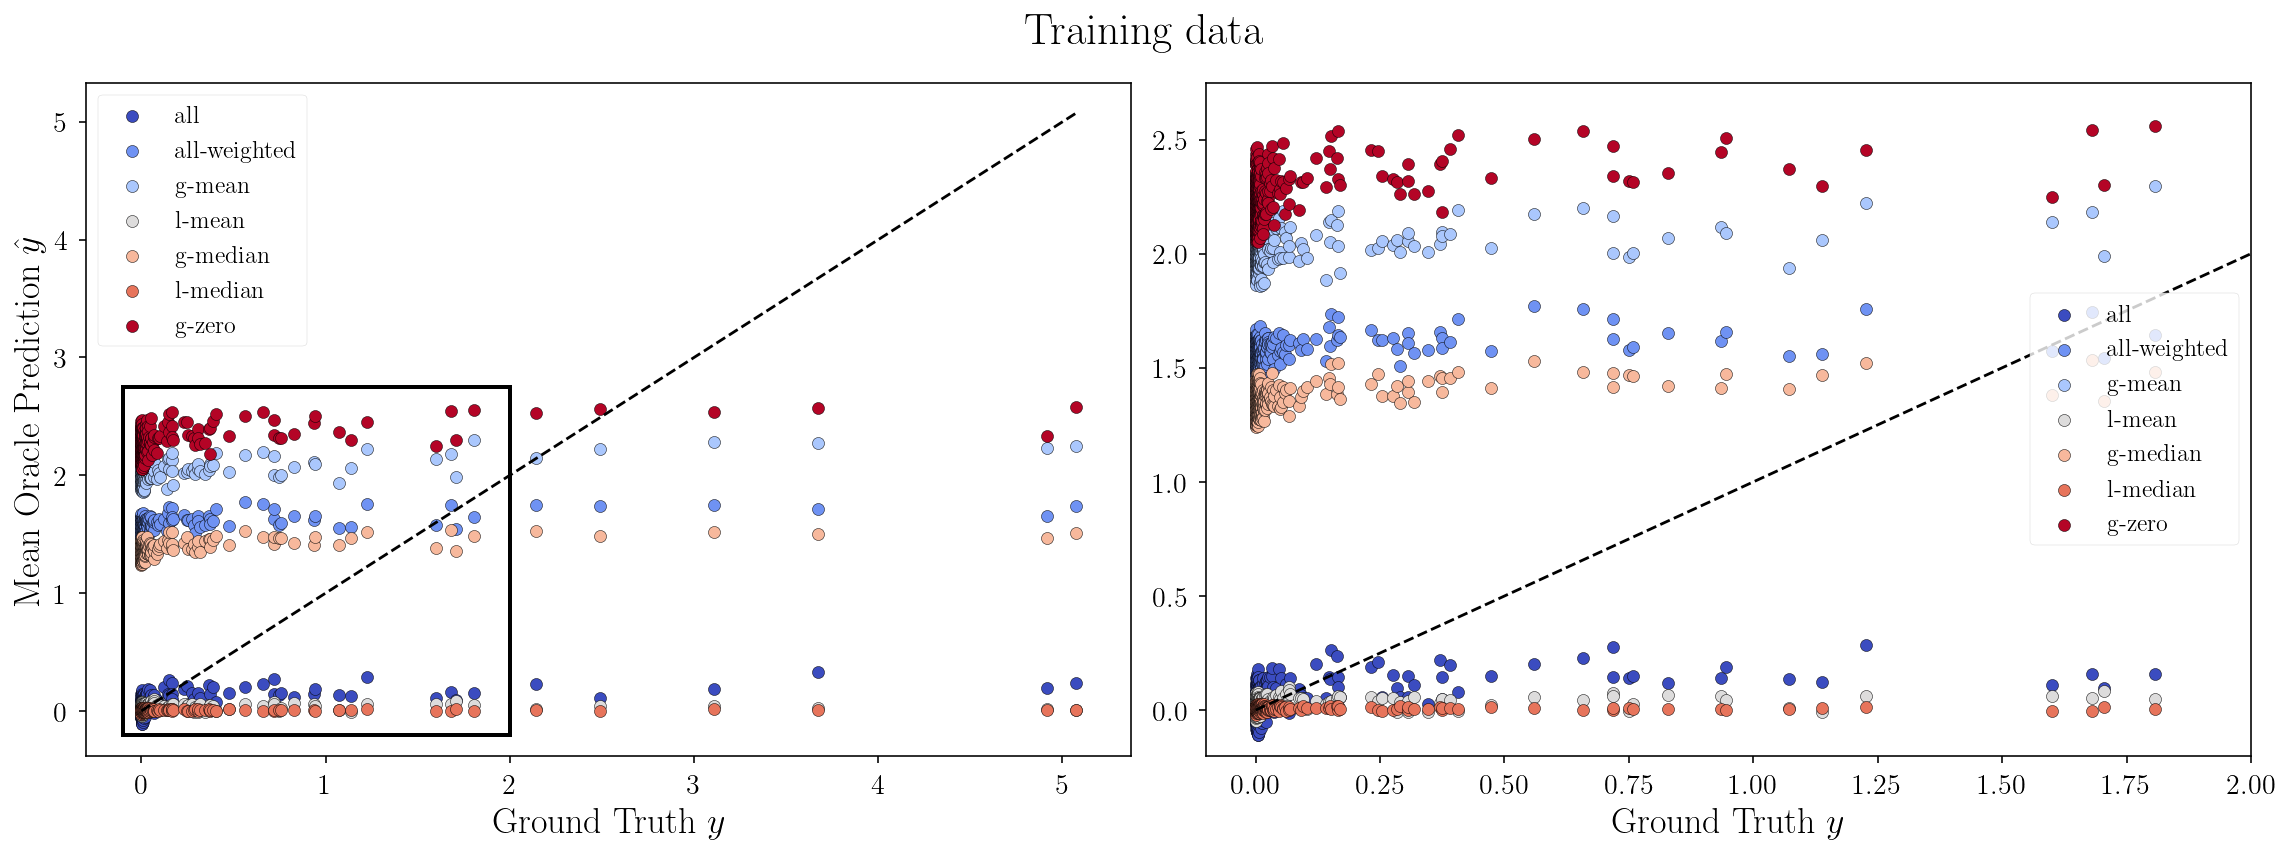

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
xy = np.linspace(_labels.min(), _labels.max()) # x = y
colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(preds)))

# First graph
handles = []
for (desc, pred), c in zip(preds.items(), colors):
    h = ax1.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
    handles.append(h)
ax1.plot(xy, xy, "--", c="black")
ax1.tick_params("both")
ax1.set_xlabel("Ground Truth $y$")
ax1.set_ylabel("Mean Oracle Prediction $\hat{y}$")
ax1.legend(handles, list(preds.keys()), scatterpoints=1)

# Add bounding box (view of 2nd graph)
bbox = np.array([-0.1, 2.75, 2, -0.2])
ax1.add_patch(bbox_to_rect(bbox, 'black'))

# Second graph
for (desc, pred), c in zip(preds.items(), colors):
    ax2.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
ax2.plot(xy, xy, "--", c="black")
ax2.tick_params("both")
ax2.set_xlabel("Ground Truth $y$")
ax2.legend(handles, list(preds.keys()), scatterpoints=1)
ax2.set_xlim(bbox[[0,2]])
ax2.set_ylim(bbox[[1,-1]][::-1])

plt.tight_layout()
fig.suptitle("Training data")
plt.subplots_adjust(top=0.9)
plt.show()

What we can see is that oracle predictions are very poor, when compared to the true GT. In fact, for most sequences, the oracle predicts approximately the same values (with some small variance). This is true even when we train the oracle on a subset of the dataset.

## GPR

In [7]:
paths = sorted(glob.glob("../../bin/3gb1/gpr/*"))
metadata = ["all", "g-mean", "l-mean", "g-median", "l-median", "g-zero"]
gpr_paths = dict(zip(metadata, paths))
gpr_paths

{'all': '../../bin/3gb1/gpr/2020-Apr-17-16:14:58.pt',
 'g-mean': '../../bin/3gb1/gpr/2020-Apr-17-16:20:23.pt',
 'l-mean': '../../bin/3gb1/gpr/2020-Apr-17-16:20:58.pt',
 'g-median': '../../bin/3gb1/gpr/2020-Apr-17-16:21:36.pt',
 'l-median': '../../bin/3gb1/gpr/2020-Apr-17-16:21:53.pt',
 'g-zero': '../../bin/3gb1/gpr/2020-Apr-17-16:24:04.pt'}

In [8]:
# Initialize and load weights for all gprs
all_gps = {desc: torch.load(path) for desc, path in gpr_paths.items()}

# Evaluate on oracle to get predictions
preds = {}
for desc, gp in all_gps.items():
    y_mean = gp.predict(Xaa, return_std=False)
    preds[desc] = y_mean

# Print topk oracle (pred) values
for desc, pred in preds.items():
    pred = pred.squeeze() # flatten array
    idx = torch.sort(pred).indices[-10:]
    print(desc.upper(), pred[idx], _labels[idx])

ALL tensor([1.3298, 1.4522, 1.6066, 1.6298, 1.7879, 2.2132, 2.8175, 3.3207, 4.2519,
        4.4255]) tensor([1.6001, 1.7055, 1.6815, 1.8073, 2.1406, 2.4872, 3.1087, 3.6708, 5.0733,
        4.9163])
G-MEAN tensor([1.6737, 1.7365, 1.9096, 1.9164, 2.2615, 2.3424, 2.8968, 3.4578, 4.4004,
        4.5637]) tensor([0.0000, 1.8073, 2.1406, 0.0083, 0.0000, 2.4872, 3.1087, 3.6708, 5.0733,
        4.9163])
L-MEAN tensor([0.0418, 0.0446, 0.0465, 0.0469, 0.0495, 0.0506, 0.0550, 0.0596, 0.0609,
        0.0620]) tensor([0.0499, 0.0480, 0.0548, 0.0510, 0.0543, 0.0581, 0.0604, 0.0662, 0.0676,
        0.0691])
G-MEDIAN tensor([1.3748, 1.4642, 1.6239, 1.6440, 1.8706, 2.2366, 2.8245, 3.3361, 4.2904,
        4.4401]) tensor([1.6001, 1.7055, 1.6815, 1.8073, 2.1406, 2.4872, 3.1087, 3.6708, 5.0733,
        4.9163])
L-MEDIAN tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0031, 0.0031, 0.0032,
        0.0034]) tensor([0.0031, 0.0031, 0.0030, 0.0046, 0.0030, 0.0075, 0.0060, 0.0039, 0.0499,
        0.0

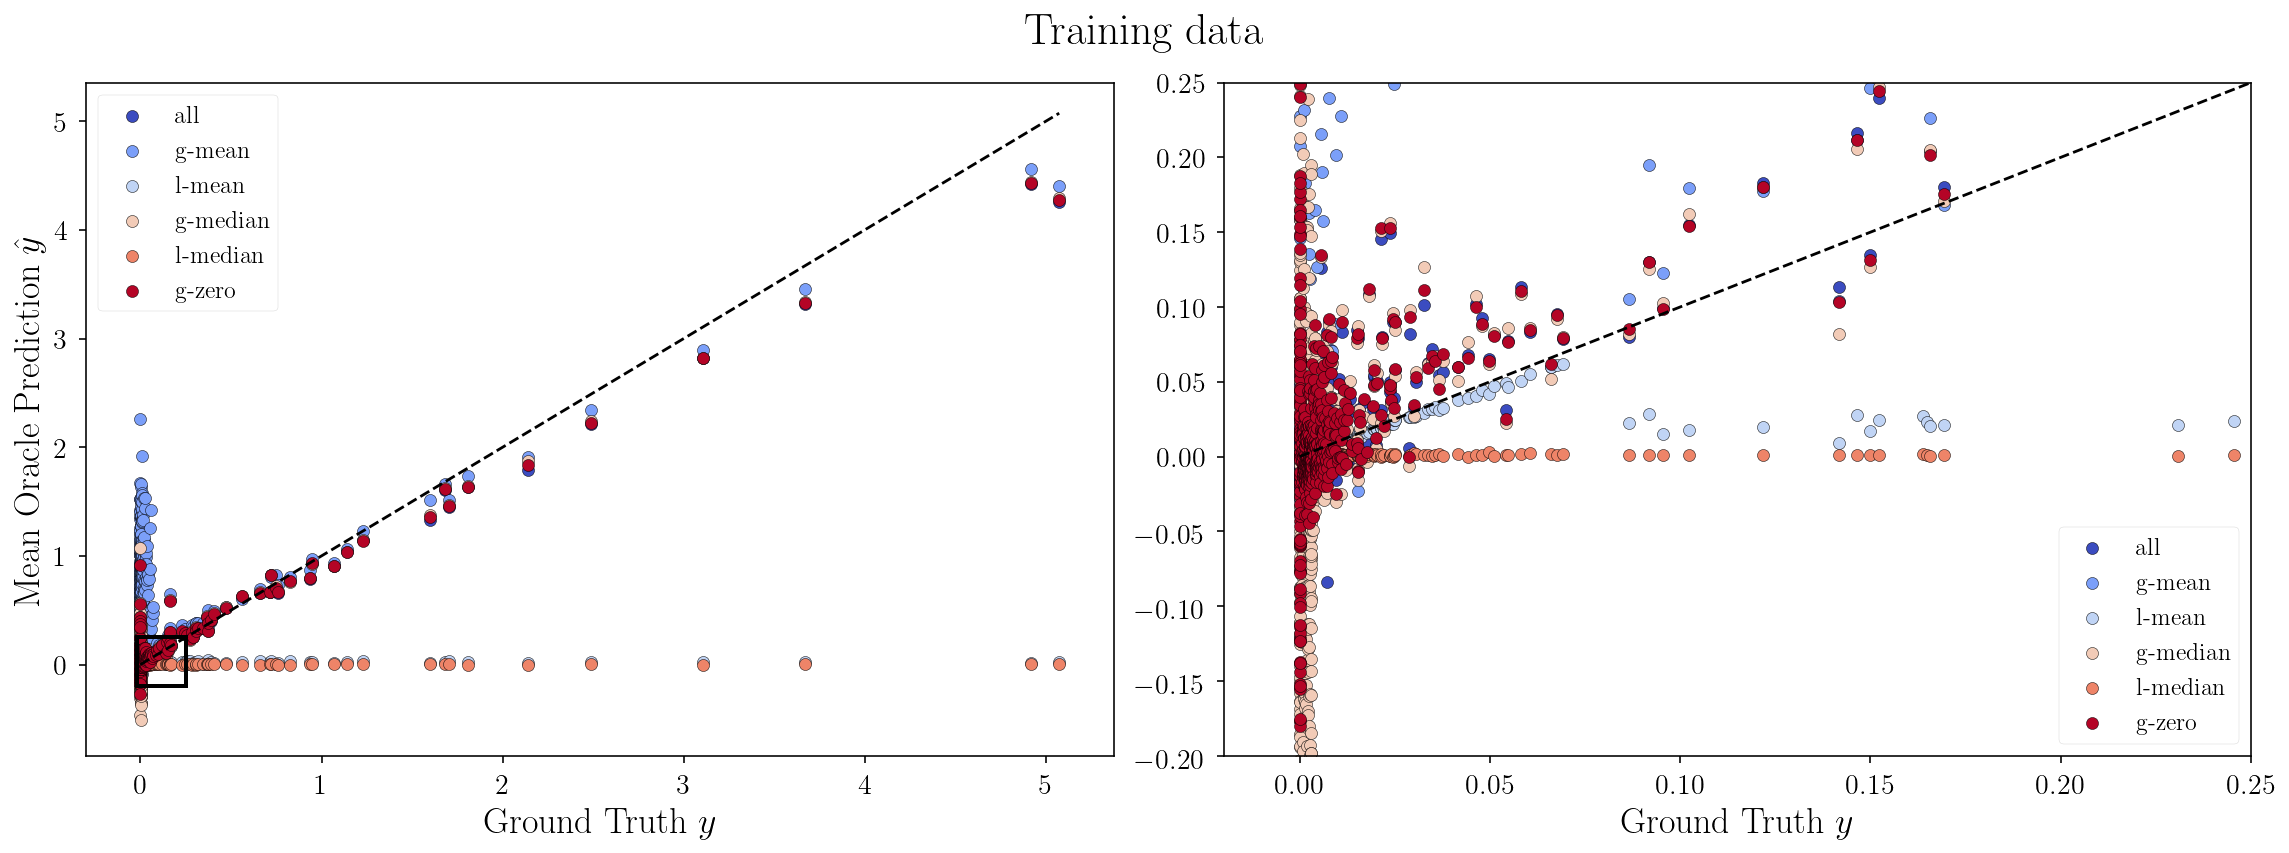

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
xy = np.linspace(_labels.min(), _labels.max()) # x = y
colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(preds)))

# First graph
handles = []
for (desc, pred), c in zip(preds.items(), colors):
    h = ax1.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
    handles.append(h)
ax1.plot(xy, xy, "--", c="black")
ax1.tick_params("both")
ax1.set_xlabel("Ground Truth $y$")
ax1.set_ylabel("Mean Oracle Prediction $\hat{y}$")
ax1.legend(handles, list(preds.keys()), scatterpoints=1)

# Add bounding box (zoomed in view of 2nd graph)
bbox = np.array([-0.02, 0.25, 0.25, -0.2])
ax1.add_patch(bbox_to_rect(bbox, 'black'))

# Second graph
for (desc, pred), c in zip(preds.items(), colors):
    ax2.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
ax2.plot(xy, xy, "--", c="black")
ax2.tick_params("both")
ax2.set_xlabel("Ground Truth $y$")
ax2.legend(handles, list(preds.keys()), scatterpoints=1)
ax2.set_xlim(bbox[[0,2]])
ax2.set_ylim(bbox[[1,-1]][::-1])

plt.tight_layout()
fig.suptitle("Training data")
plt.subplots_adjust(top=0.9)
plt.show()

What we can see is that predictions are good, but often a little lower than true GT. This might be because a lot of sequences in the original dataset are 0. Even if we train the kernel on the sequences that are greater than 0, the performance is still sub-par at best.

# Condition by Adaptive Sampling (CbAS)

## Select optimal oracle/gp

We want to select the oracle and GT in such a fashion that (a) the oracle values are somewhat improving with each iteration and (b) the GT is not falling substantially (aka being led astray into "poor" regions of the search space) with each iteration. Although not strictly required, it is also important to select the oracle/GT such that the initial training dataset used to train both is the same.

What do we do if the oracle is particularly bad at determining the fitness values between good and bad sequences? This is what is currently happening (see above).

In [10]:
cbas_files = sorted(glob.glob("../../dumps/3gb1/cbas/*.json"))
cbas_files[:5]

['../../dumps/3gb1/cbas/oracle=all-weighted__gp=all.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=g-mean.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=g-median.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=g-zero.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=l-mean.json']

Text(0, 0.5, '$y_{\\mathrm{gt}}$')

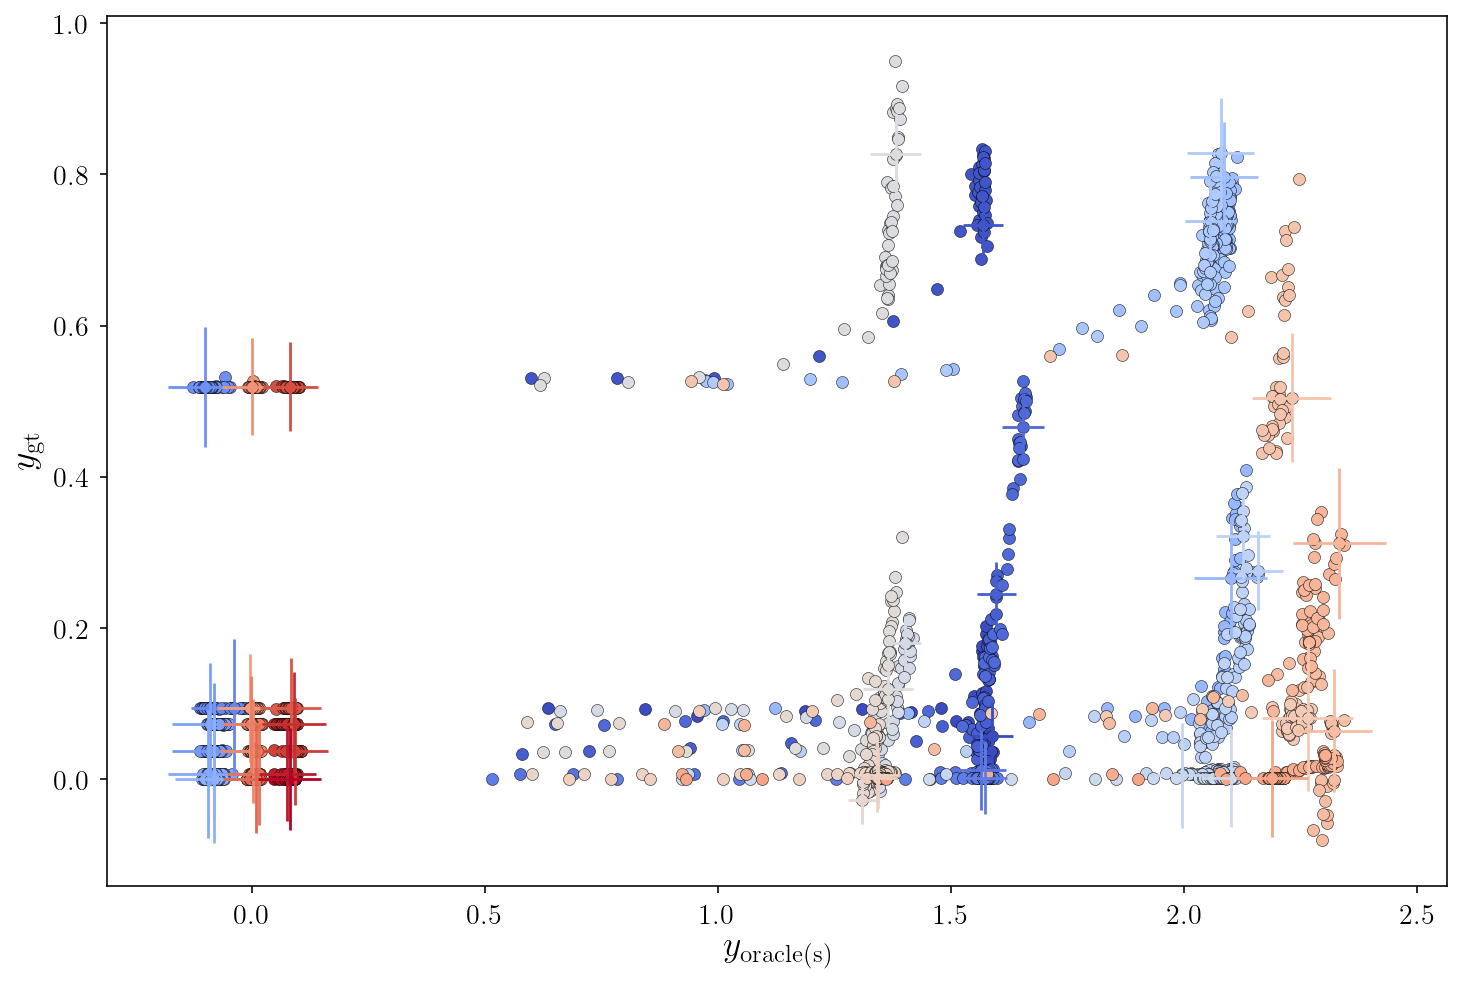

In [11]:
colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(cbas_files)))
plt.figure(figsize=(12,8))

for file, c in zip(cbas_files, colors):
    with open(file, "rb") as json_file:
        values = json.load(json_file)
        # Compute mean and std of the samples for each experiment
        oracle_mean = np.mean(np.ma.masked_invalid(values["y_oracle"]), axis=-1)
        oracle_std = np.std(np.ma.masked_invalid(values["y_oracle"]), axis=-1)
        gt_mean = np.mean(np.ma.masked_invalid(values["y_gt"]), axis=-1)
        gt_std = np.mean(np.ma.masked_invalid(values["y_gt"]), axis=-1)
        # Plot results (error bars for last iteration)
        plt.scatter(oracle_mean, gt_mean, color=c, edgecolors="black")
        plt.errorbar(oracle_mean[-1], gt_mean[-1], xerr=oracle_std[-1], yerr=oracle_std[-1],
                     color=c, fmt='none')

plt.xlabel(r"$y_{\mathrm{oracle(s)}}$")
plt.ylabel(r"$y_{\mathrm{gt}}$")

Generally, we see that as number of iterations increase, both the GT and the oracle predictions (for the samples in that sequence) increases until the oracle reaches its asymptotic upper limit. This means that we have likely converge onto a decent sequence candidate set of sequences (within each iteration) which are not contained in the original dataset. Note that the GT values is largely ignored (still useful to determine if the model is not being led into "bad" sequence regions of the search space).

We want to plot the trajectory of the top sequence (for both the oracle and the GT) across each of the 42 different runs. This will help us determine which is the "best" subset of the dataset to train the model(s) on. For instance, if the GT does not decrease substantially while the oracle is predicting high values that means the dataset is doing good.

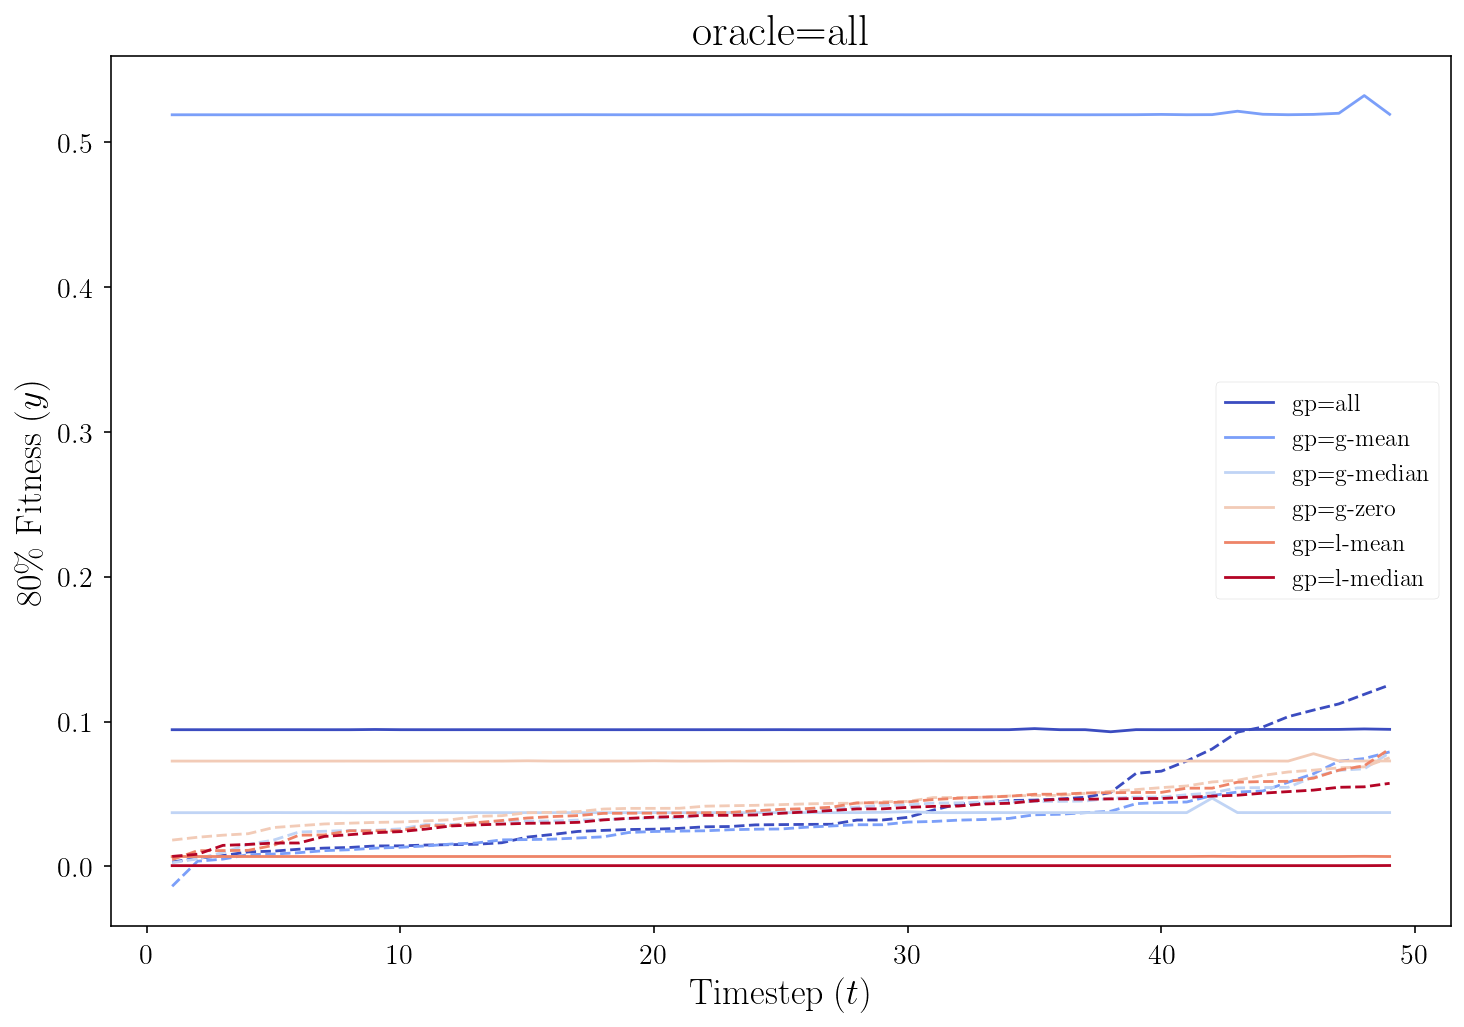

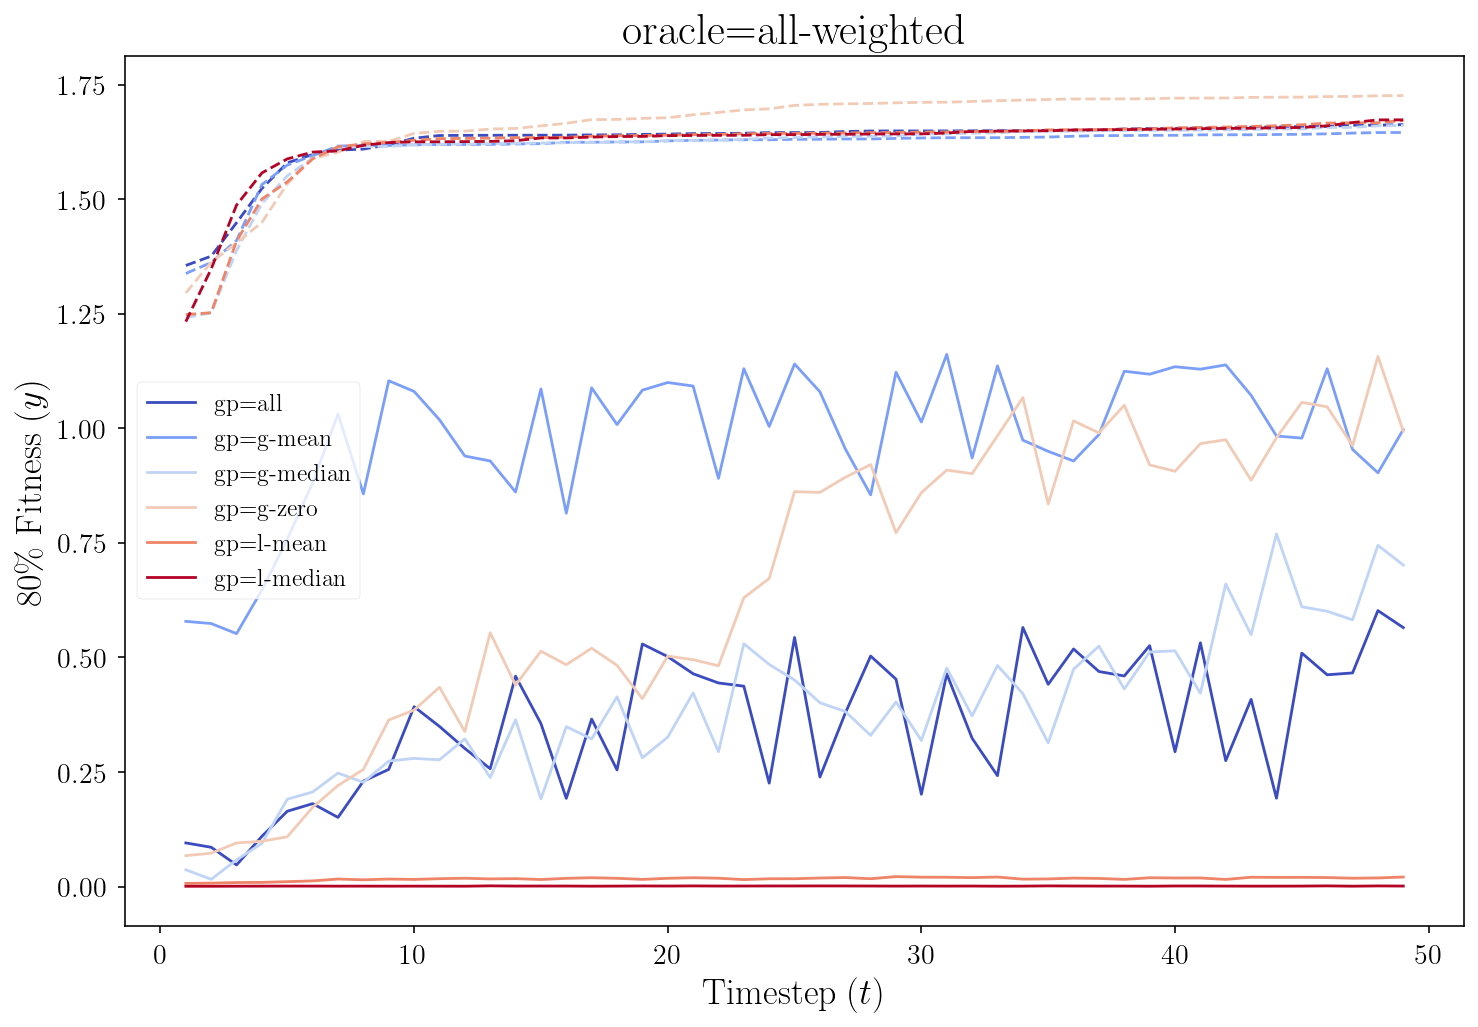

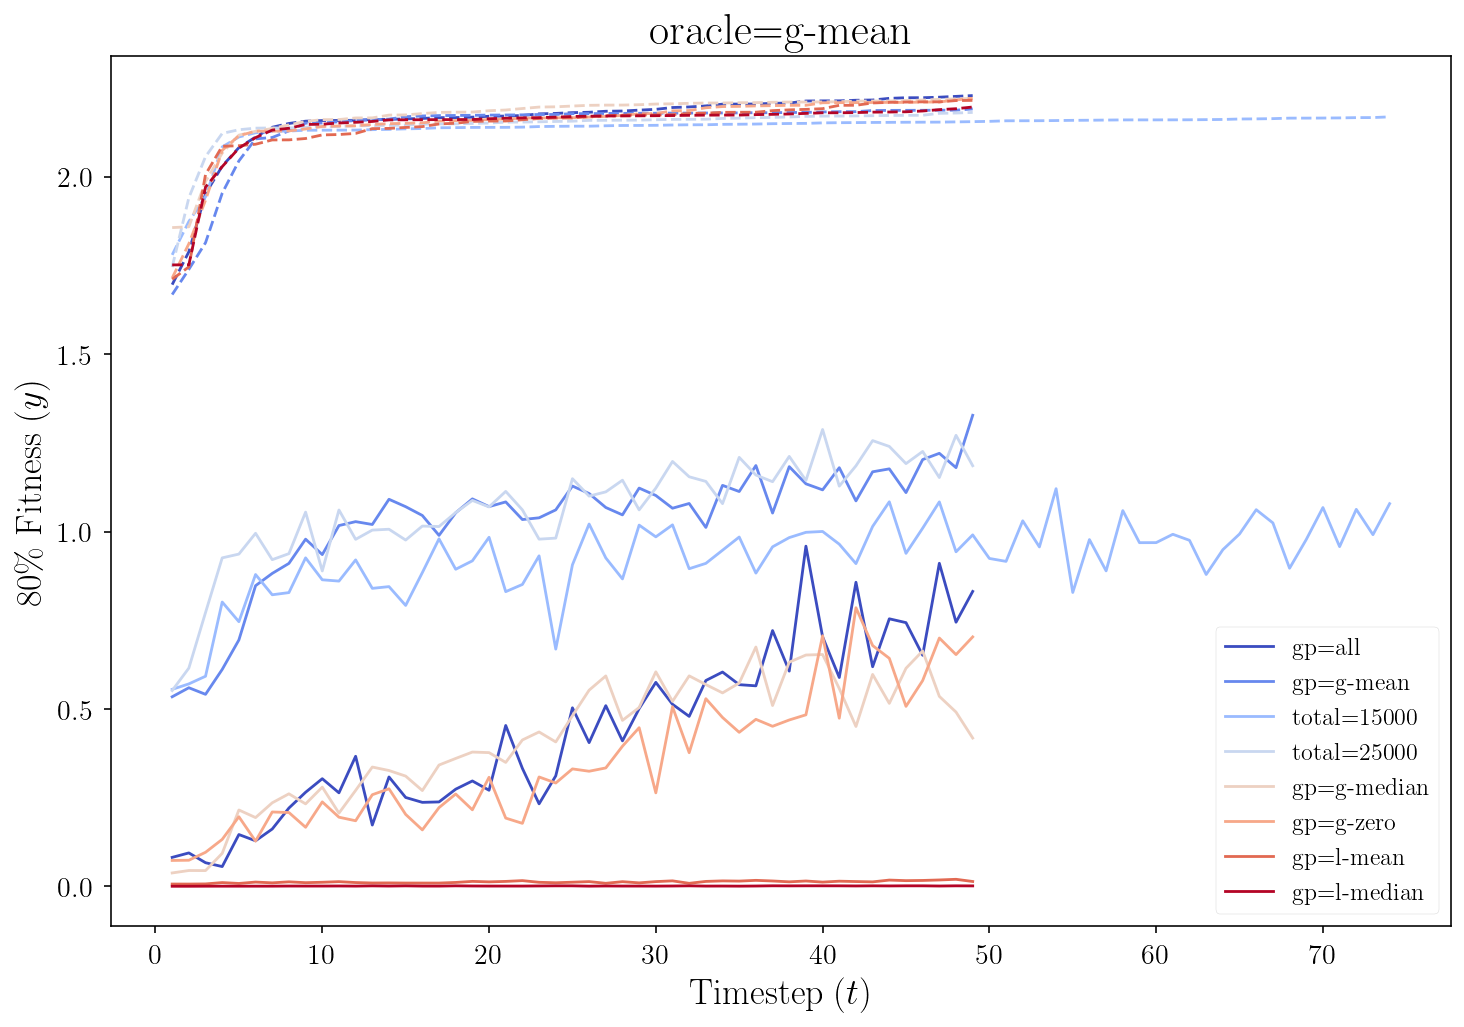

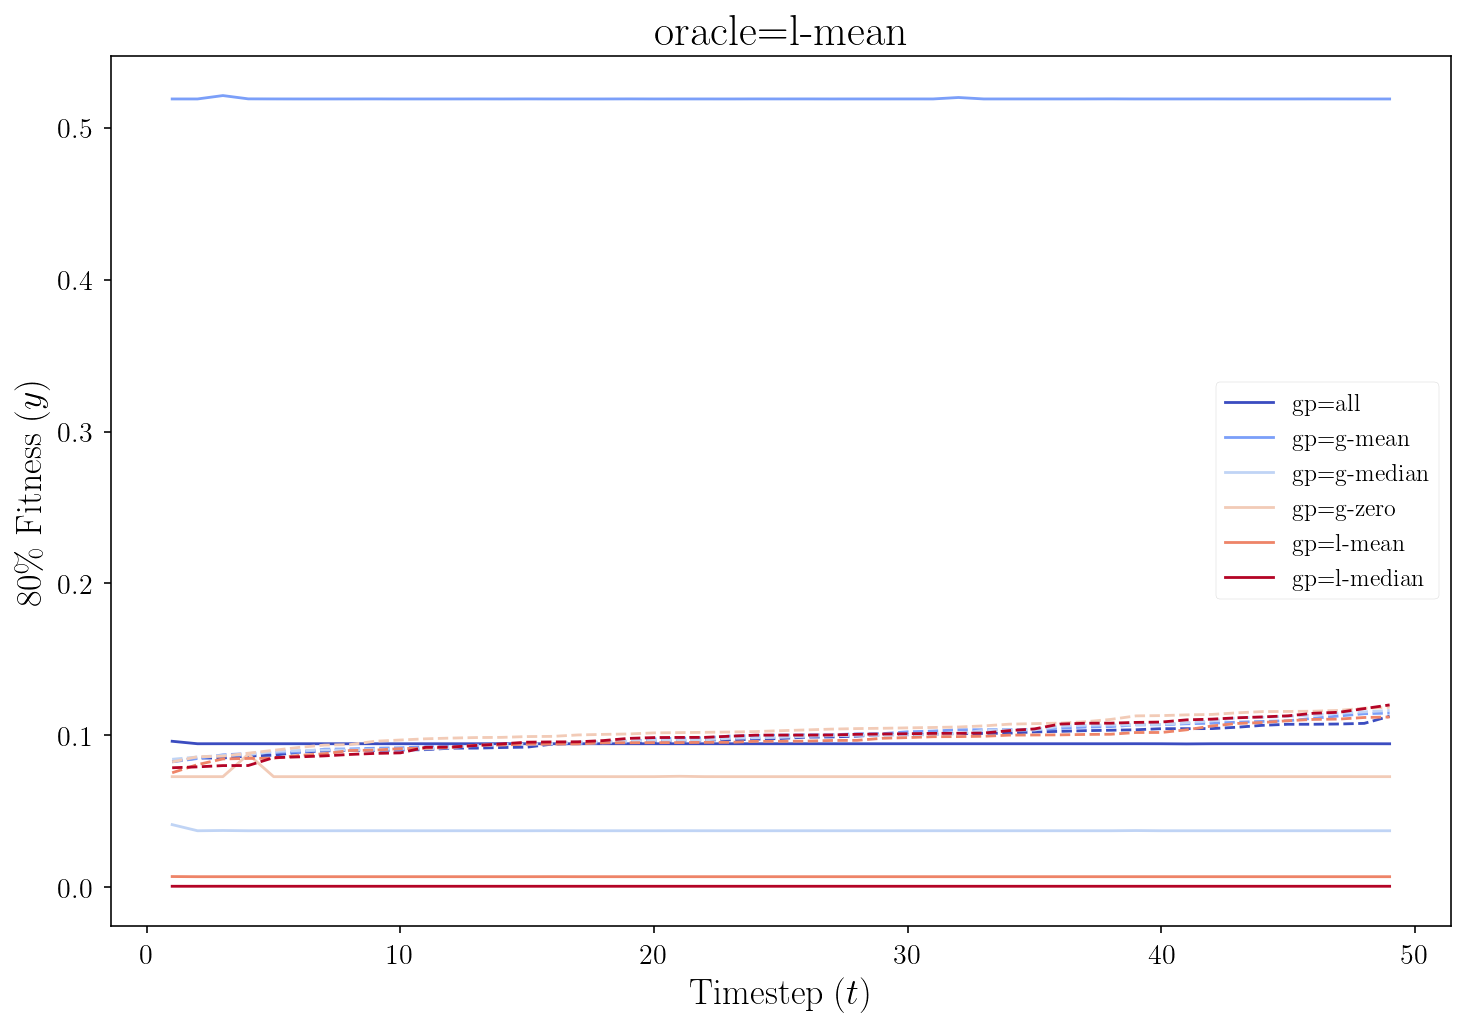

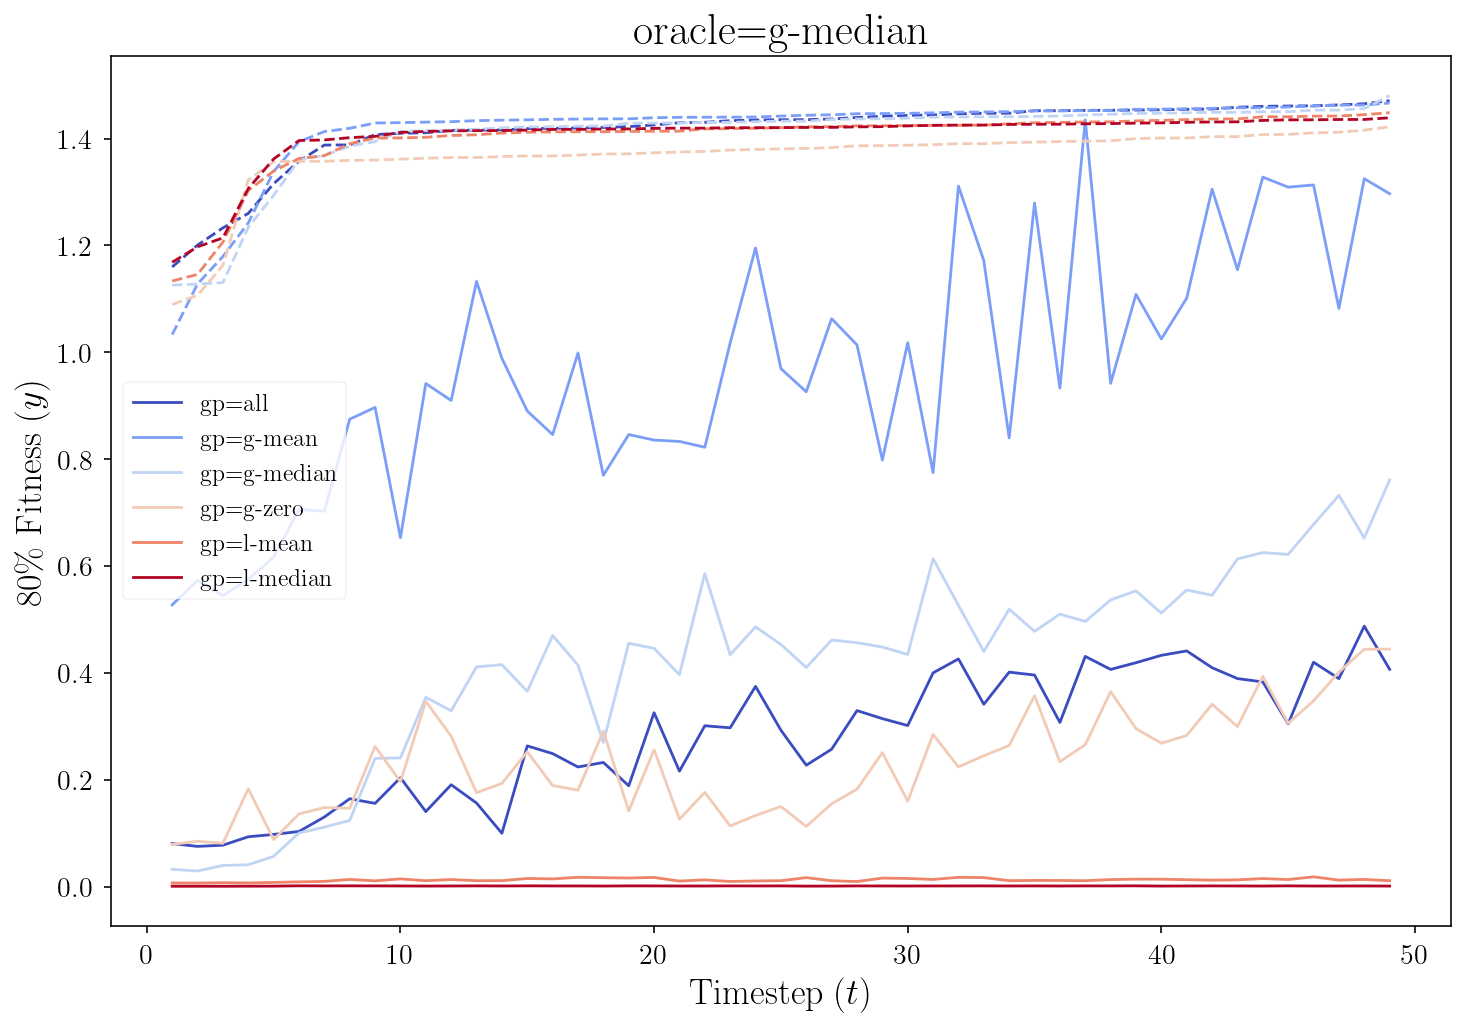

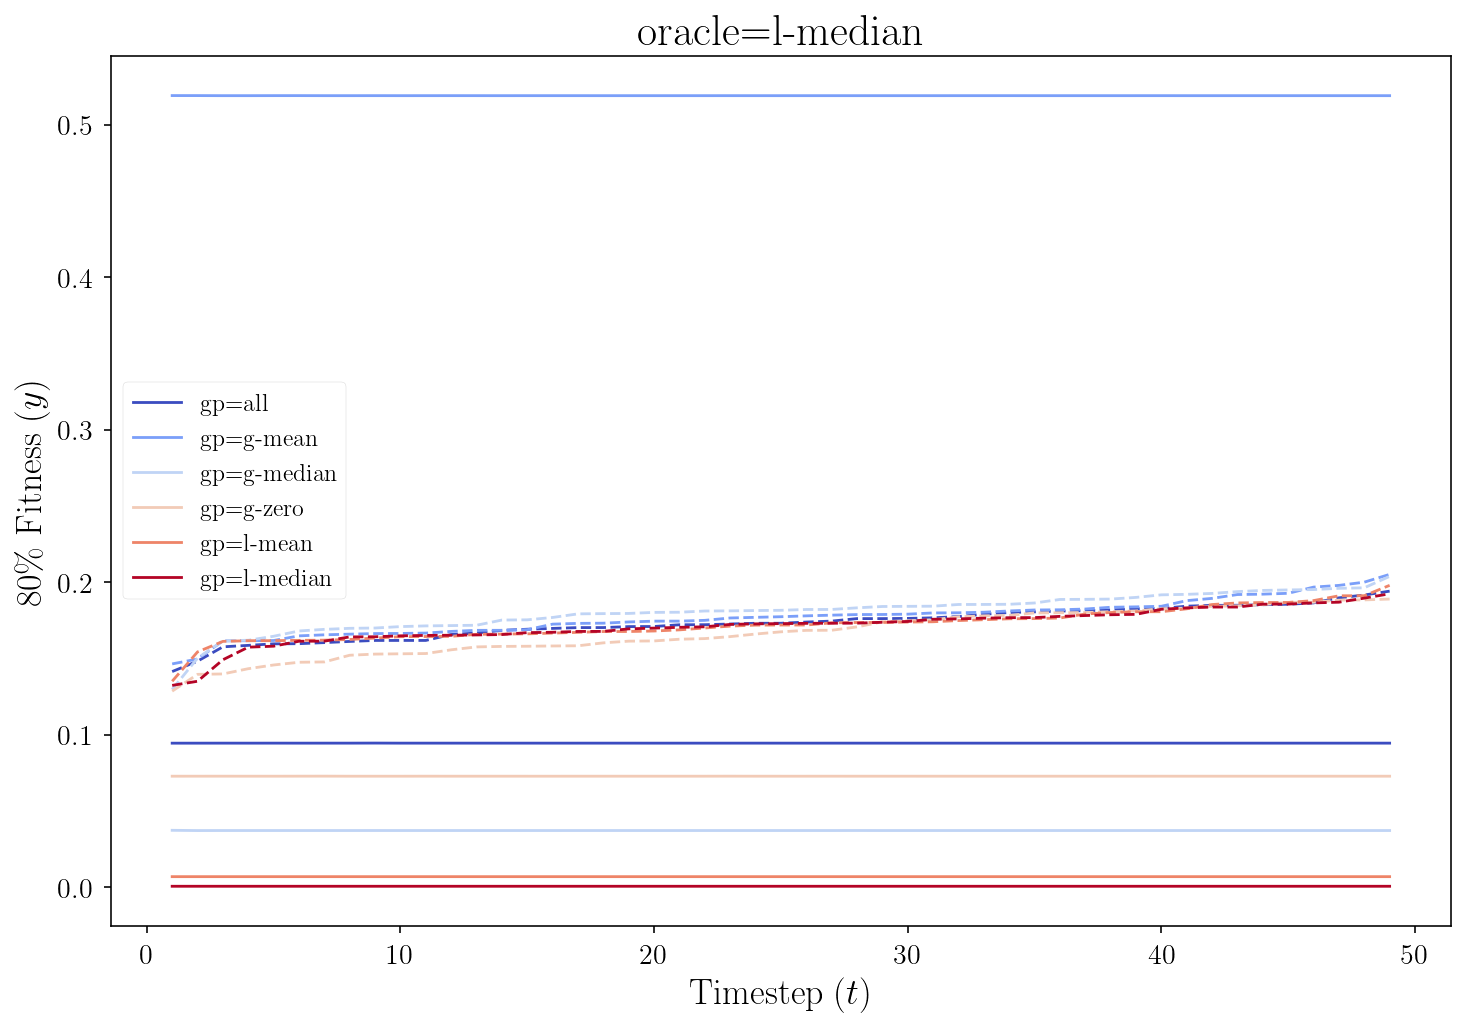

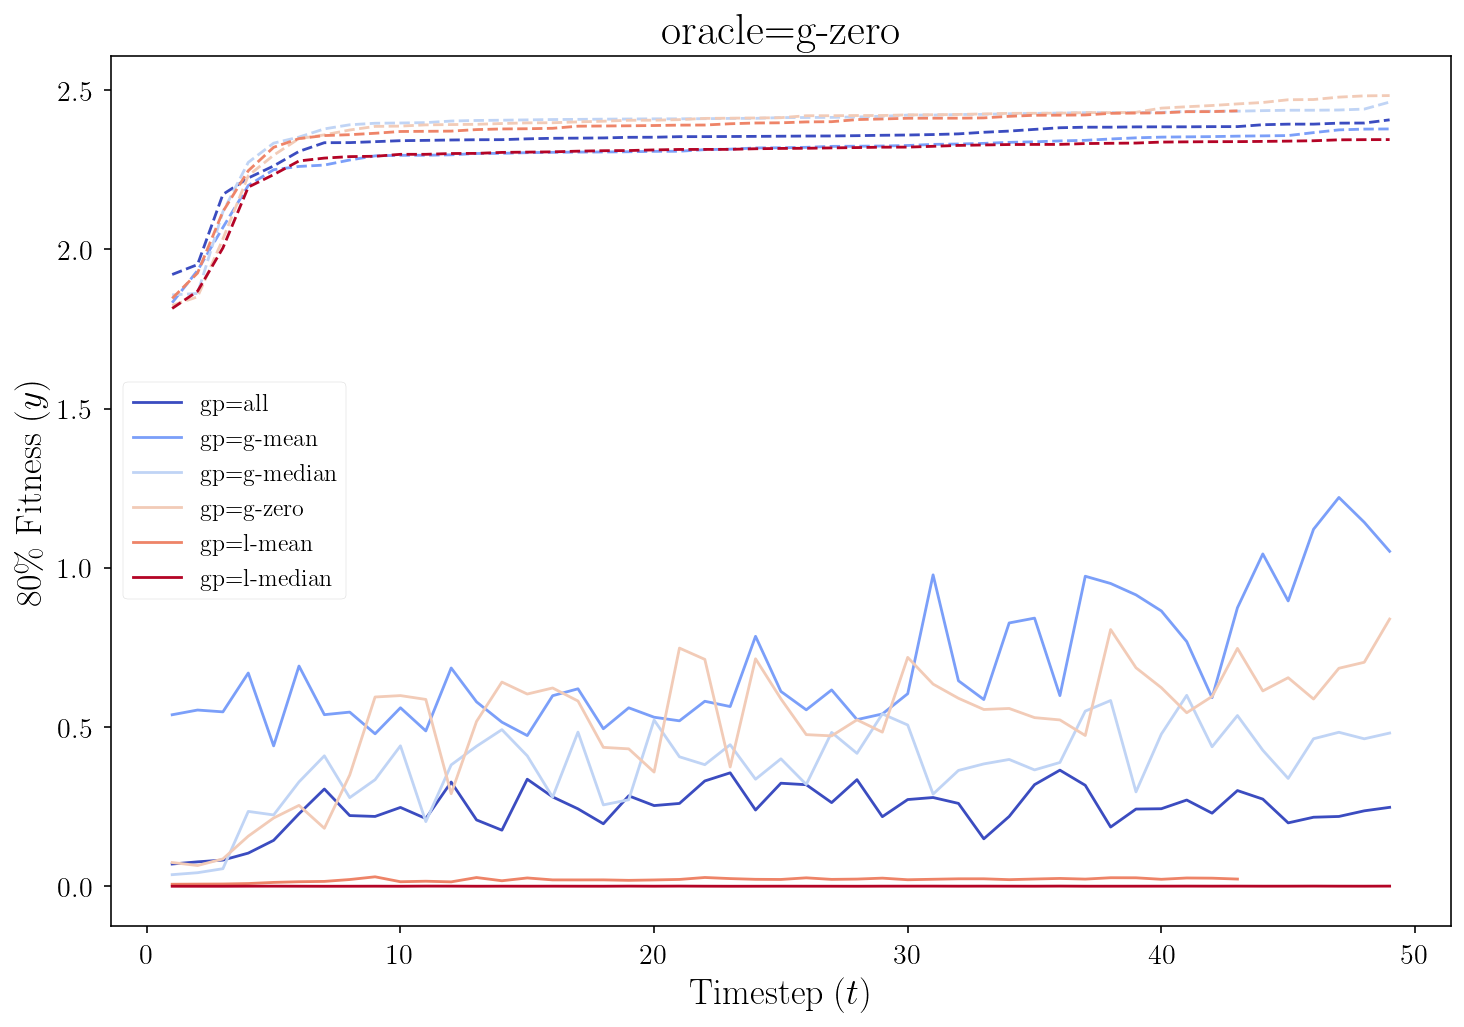

In [12]:
quantile = 0.80
sort = True

for oracle_key in oracle_paths.keys():
    # Gather values (for all GPs) for specified oracle
    plt.figure(figsize=(12,8))
    filepaths = [file for file in cbas_files if f"oracle={oracle_key}__" in file]
    gp_keys = [os.path.split(file)[-1].split(".")[0].split("__")[-1] for file in filepaths]
    colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(filepaths)))
    for file, gp_key, c in zip(filepaths, gp_keys, colors):
        with open(file, "rb") as json_file:
            values = json.load(json_file)
        # Compute 80th percentile range for y_oracle
        oracle_samples = np.ma.masked_invalid(values["y_oracle"])
        per = np.percentile(oracle_samples, quantile*100, axis=-1)
        per = np.reshape(per, newshape=(oracle_samples.shape[0], 1))
        oracle_idxs = np.where(oracle_samples > per)
        
        # Average values for samples that are greater than quantile
        oracle_vals = np.zeros_like(oracle_samples)
        oracle_vals[oracle_idxs] = oracle_samples[oracle_idxs]
        oracle_vals = oracle_vals.sum(1) / (oracle_vals != 0).sum(1)
        
        gt_samples = np.ma.masked_invalid(values["y_gt"])
        gt_vals = np.zeros_like(gt_samples)
        gt_vals[oracle_idxs] = gt_samples[oracle_idxs]
        gt_vals = gt_vals.sum(1) / (gt_vals != 0).sum(1)
        
        # Sort oracle values (ascending) when plotting
        if sort:
            oracle_idxs = np.argsort(oracle_vals)
            oracle_vals = oracle_vals[oracle_idxs]
            gt_vals = gt_vals[oracle_idxs]
        
        # Plot values
        plt.plot(np.arange(1, len(oracle_vals)+1), oracle_vals, color=c, linestyle="dashed")
        plt.plot(np.arange(1, len(gt_vals)+1), gt_vals, color=c, label=gp_key)
    plt.xlabel("Timestep ($t$)")
    plt.ylabel(f"${quantile * 100:.0f}\%$ Fitness ($y$)")
    plt.title(f"oracle={oracle_key}")
    plt.legend()
    plt.show()

## Topk (k=10) sequences

From the above trajectories, it seems that no matter the oracle used, the GP trained on indices greater than the mean, seems to perform well in that it does not explore "poor" regions of the sequence-space (as evidence by the fact that the GP remains around its max value). As for the oracle, the best seems to be g-mean/g-median/g-zero as well (since they produce high GT values). Should we compare the topk sequences from each of these runs to see if they concur on similar sequences?

In [13]:
with open("../../dumps/3gb1/cbas/oracle=g-mean__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)

# What are the topk sequences and their predicted oracle/GT values
oracles = np.array(results["y_oracle"]).flatten()
topk_idx = np.argsort(oracles)[-10:]

seq_topk = np.array(results["seq"]).flatten()[topk_idx]
yt_topk = oracles[topk_idx]
yt_gt_topk = np.array(results["y_gt"]).flatten()[topk_idx]

print(yt_topk)
print(yt_gt_topk)
print(seq_topk)

[2.2608285  2.26124024 2.26129508 2.26188922 2.263412   2.26624298
 2.27156091 2.27882648 2.28198576 2.30062079]
[2.5723331  1.56457329 1.35173917 0.96995664 1.8256042  1.40203524
 1.1934669  1.3307023  1.83533025 1.42698431]
['MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWAEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSWREWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWGEWTYDDATKTFTMTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIWGEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQHGEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWGEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSHCEWTYDDATKTFTMTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSWCEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWMEWTYDDATKTFTCTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSWMEWTYDDATKTFTCTE']


In [14]:
with open("../../dumps/3gb1/cbas/oracle=g-median__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)

# What are the topk sequences and their predicted oracle/GT values
oracles = np.array(results["y_oracle"]).flatten()
topk_idx = np.argsort(oracles)[-10:]

seq_topk = np.array(results["seq"]).flatten()[topk_idx]
yt_topk = oracles[topk_idx]
yt_gt_topk = np.array(results["y_gt"]).flatten()[topk_idx]

print(yt_topk)
print(yt_gt_topk)
print(seq_topk)

[1.51794326 1.52096236 1.52098393 1.52116716 1.52193272 1.52455473
 1.52462912 1.52462912 1.52745283 1.52745283]
[ 0.74926686 -0.09591556  0.40577173  1.76790595  1.50167131  2.09452367
  0.51204348  0.51204348  0.40156412  0.40156412]
['MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAWAEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMICEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAYCEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGHWGEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGWYGEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAYGEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAIGEWTYDDATKTFTGTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAIGEWTYDDATKTFTGTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAWGEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAWGEWTYDDATKTFTTTE']


In [15]:
with open("../../dumps/3gb1/cbas/oracle=g-zero__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)

# What are the topk sequences and their predicted oracle/GT values
oracles = np.array(results["y_oracle"]).flatten()
topk_idx = np.argsort(oracles)[-10:]

seq_topk = np.array(results["seq"]).flatten()[topk_idx]
yt_topk = oracles[topk_idx]
yt_gt_topk = np.array(results["y_gt"]).flatten()[topk_idx]

print(yt_topk)
print(yt_gt_topk)
print(seq_topk)

[2.50903273 2.50994754 2.52963352 2.53185821 2.53290987 2.53427744
 2.53625894 2.54033351 2.54363275 2.54579139]
[0.66505122 1.08065224 1.31846261 1.31186318 1.72883749 2.60042977
 2.32762671 1.41607952 1.84557629 1.61942315]
['MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIILEWTYDDATKTFTWTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGHYFEWTYDDATKTFTWTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSYCEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQHCEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQYCEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEYAEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIYGEWTYDDATKTFTCTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIYGEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIYGEWTYDDATKTFTGTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGHYGEWTYDDATKTFTDTE']


# Mutation heatmap

In [16]:
import pandas as pd
import seaborn as sns

from profit.dataset import generator
from profit.dataset.preprocessors import LSTMPreprocessor

In [17]:
positions = np.arange(20, 56)
num_mutation_sites = len(positions)
seqs = generator.gen(n=1)

In [18]:
# Permute each position with amino acid
preprocessor = LSTMPreprocessor(vocab="aa20")
all_seqs = []
for pos in positions:
    for seq in seqs:
        template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
        template[pos] = seq
        all_seqs.append(preprocessor.get_input_feats(template))
all_seqs = torch.Tensor(all_seqs).long()

# Convert to onehot
S = torch.zeros(*all_seqs.size(), vocab_size)
S.scatter_(2, torch.unsqueeze(all_seqs, dim=2), 1)

# Evaluate on (g-mean) oracle to get predictions
gmean_oracle = all_oracles["g-mean"]
if isinstance(gmean_oracle, SequenceGPR):
    mu_oracle, sigma_oracle = gmean_oracle.predict(all_seqs, return_std=True)
    mu_oracle, sigma_oracle = mean_oracle.squeeze(), sigma_oracle.squeeze()
else:
    gmean_oracle.eval()
    with torch.no_grad():
        y_pred = gmean_oracle(S)
        mu_oracle, sigma_oracle = y_pred[:,0], torch.sqrt(y_pred[:,1])

Text(0.5, 1.0, 'Protein fitness (PDB: 3GB1)')

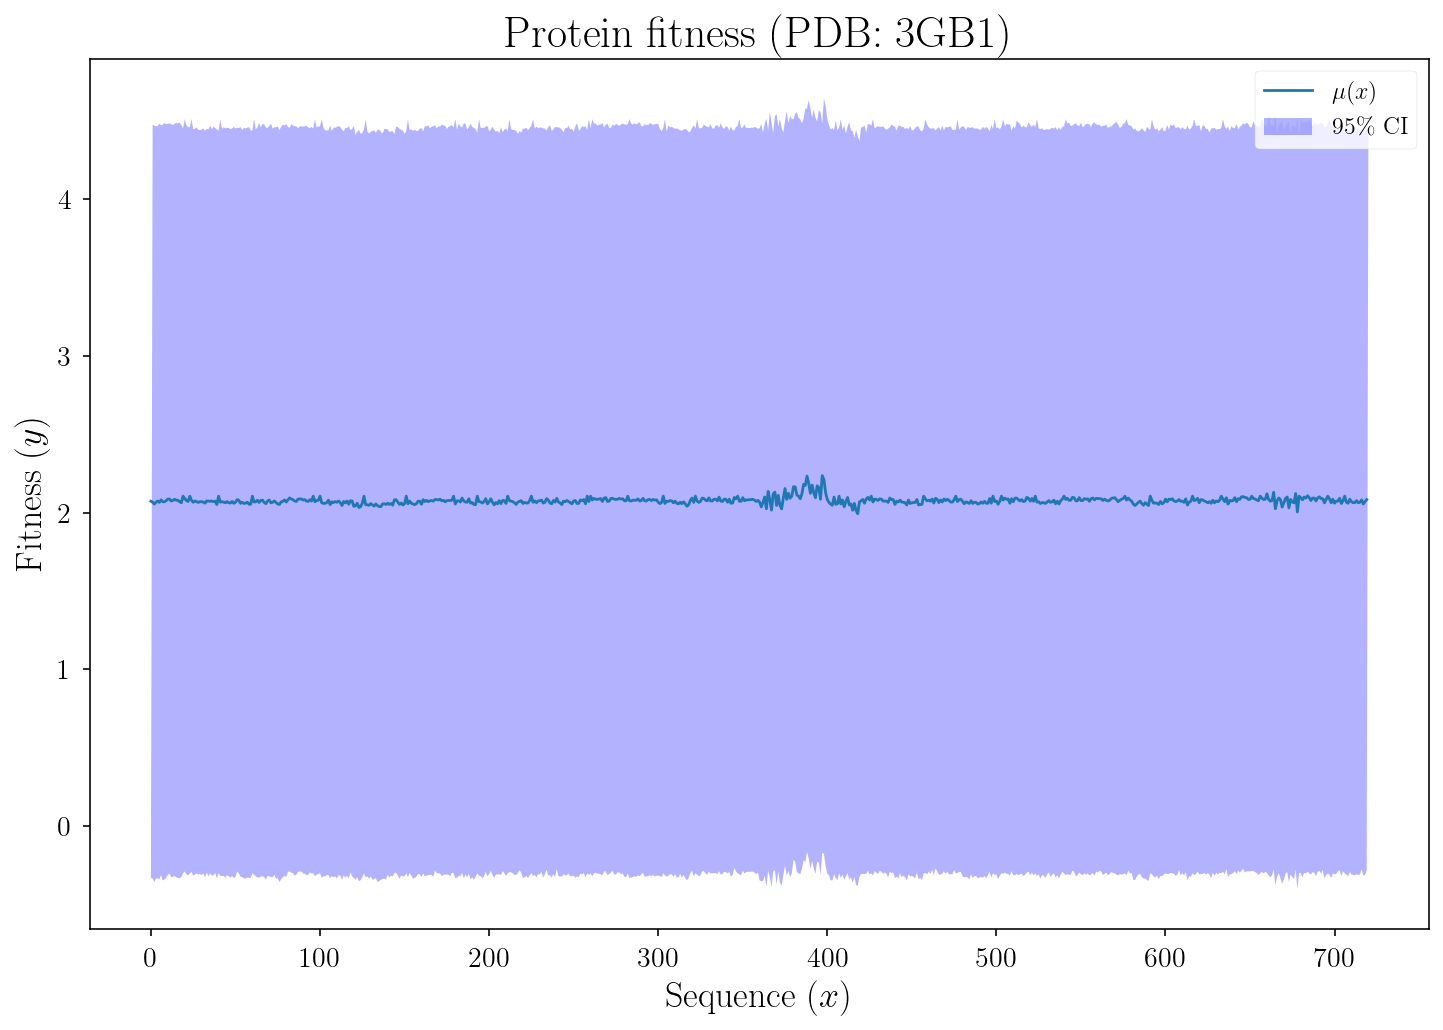

In [19]:
plt.figure(figsize=(12,8))
plt.plot(mu_oracle, label="$\mu(x)$")
plt.fill(np.concatenate([torch.arange(sigma_oracle.size(0)),
                         torch.arange(sigma_oracle.size(0), 0, -1)]),
         np.concatenate([mu_oracle - 1.96 * sigma_oracle,
                         torch.flip(mu_oracle + 1.96 * sigma_oracle, dims=(0,))]),
         alpha=0.3, fc="b", ec="None", label=r"95\% CI")
plt.xlabel("Sequence ($x$)")
plt.ylabel("Fitness ($y$)")
plt.legend()
plt.title("Protein fitness (PDB: 3GB1)")

In [20]:
mu_oracle = mu_oracle.view(num_mutation_sites, vocab_size)
# # TODO: Impute WT sequences to have fitness=1???
# means[torch.floor(wt_pos_idx).long(), torch.floor(wt_aa_idx).long()] = 1.
# sns.heatmap(means, square=True, cmap="coolwarm")

In [21]:
topk = 5
max_pos = torch.max(mu_oracle, dim=-1) # max value per position
# Sort in descending order so numbers can be displayed properly
topk_pos_idx = torch.sort(max_pos.values, descending=True).indices[:topk]
topk_aa_idx = max_pos.indices[topk_pos_idx]
topk_vals = max_pos.values[topk_pos_idx]

# Create (numbered) annotation labels
topk_labels = torch.zeros_like(mu_oracle).long()
topk_labels[topk_pos_idx, topk_aa_idx] = torch.arange(1, topk_pos_idx.size(0)+1)

# Create (wildtype) annotation labels
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
Xaa_wt = torch.Tensor(preprocessor.get_input_feats(template))
wt_pos_idx = torch.arange(len(positions)).float()
wt_aa_idx = Xaa_wt[positions]
# Workaround: adjust positions so that scatter points are centered on heatmap 
wt_pos_idx += 0.5
wt_aa_idx += 0.5

In [22]:
# NOTE: we add 1 to index since python index starts at 0
df = pd.DataFrame(mu_oracle.numpy(), index=positions+1, columns=seqs).rename_axis(
    "VP Position", axis="index").rename_axis("Amino Acid", axis="columns")
df.head()

Amino Acid,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
VP Position,,,,,,,,,,,,,,,,,,,,
21,2.073645,2.068214,2.055560,2.066757,2.074990,2.066438,2.082170,2.070497,2.070006,2.076775,2.087235,2.087442,2.074903,2.079231,2.085962,2.079545,2.079515,2.070566,2.063583,2.105948
22,2.090938,2.077446,2.072361,2.105948,2.079284,2.066799,2.074761,2.070948,2.066107,2.070620,2.070627,2.068402,2.061372,2.075673,2.074778,2.073367,2.074955,2.070564,2.074314,2.052745
23,2.105948,2.067818,2.070295,2.068120,2.063974,2.071270,2.064122,2.061795,2.072274,2.060490,2.066771,2.083793,2.079703,2.060174,2.066010,2.059108,2.061741,2.067032,2.054606,2.054958
24,2.105948,2.068453,2.069999,2.079967,2.065724,2.079272,2.080460,2.065381,2.058110,2.076075,2.081257,2.063422,2.066932,2.075413,2.065282,2.055734,2.053246,2.068906,2.072992,2.081823
25,2.068462,2.082002,2.094965,2.087726,2.083470,2.075176,2.072335,2.086964,2.088492,2.087214,2.081275,2.083684,2.074062,2.072461,2.083603,2.074548,2.105948,2.070086,2.078193,2.079758


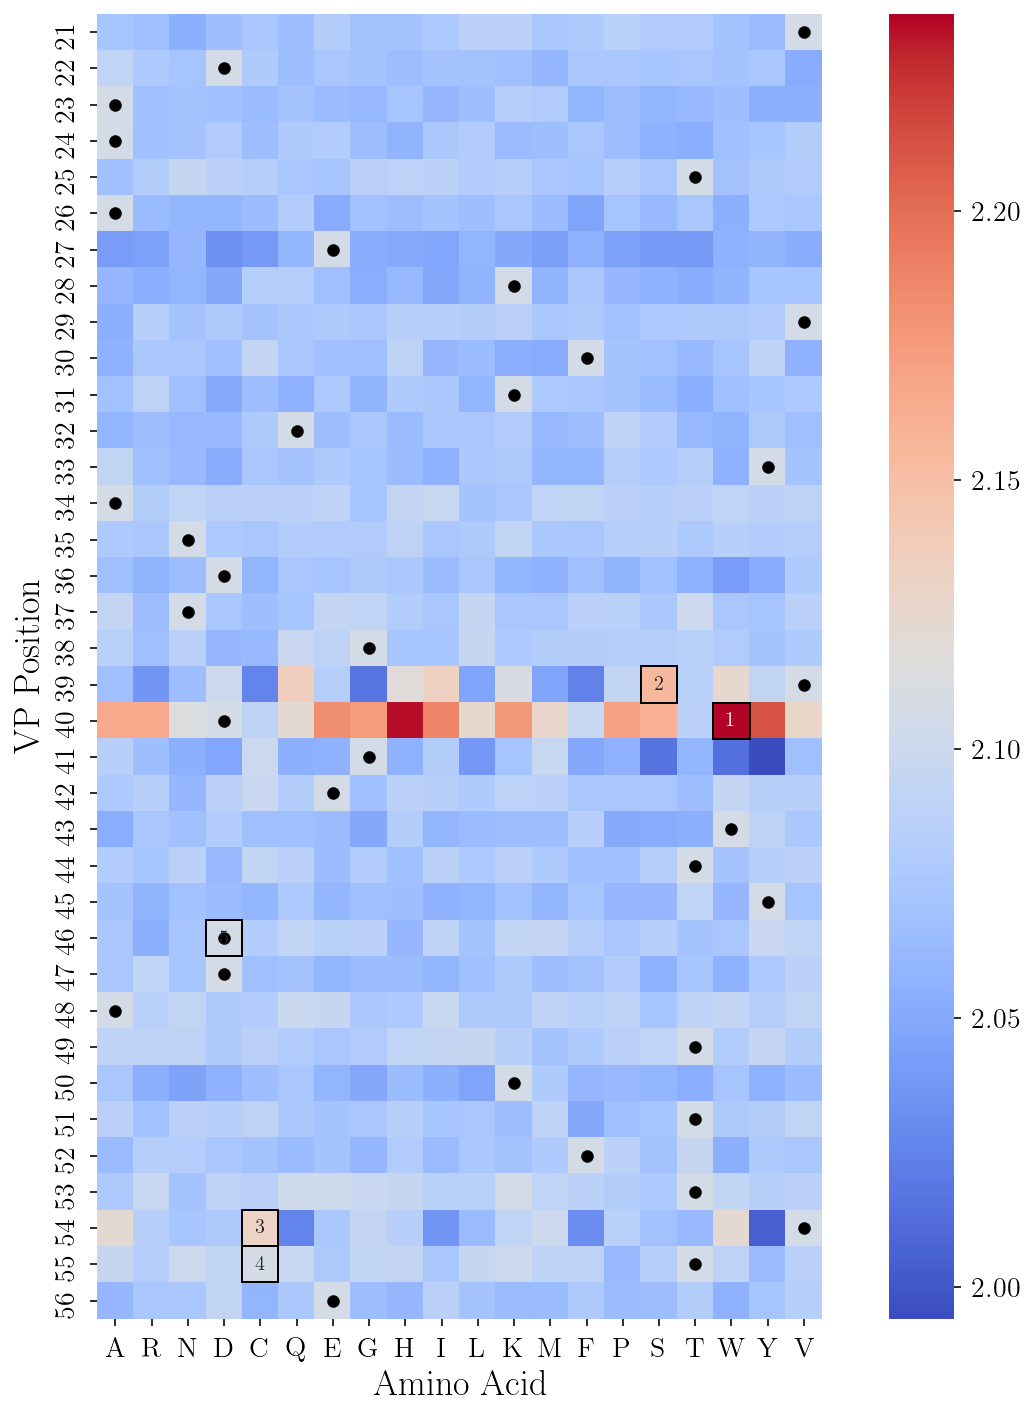

In [23]:
plt.figure(figsize=(12,12))
# Plot topk labels on top of other mutations so that numbers can be displayed
ax = sns.heatmap(df, cmap="coolwarm", square=True)
ax = sns.heatmap(df, cmap="coolwarm", square=True, annot=topk_labels, fmt="d",
            mask=(topk_labels==0).numpy(), cbar=False)
# Highlight topk sequences (w/ bbox)
for pos_idx, aa_idx in zip(topk_pos_idx.numpy(), topk_aa_idx.numpy()):
    ax.add_patch(plt.Rectangle(xy=(aa_idx, pos_idx), width=1, height=1,
                               fill=False, edgecolor='black', lw=1.0))
# Denote WT amino acid (w/ points)
plt.scatter(wt_aa_idx, wt_pos_idx, marker='o', color='black')

So the positions 39,40,53 are the most informative since most amino acid substitutions result in a higher fitness score than the rest. It is, however, important to note that this only takes into account 1 mutation position. In fact, as the number of mutation sites increase, the effects of multi-site mutations no longer become additive, but rather get closer and closer to the WT fitness.

# Trajectory (sequence space)

Show that oracle optimized using the CbAS algorithm is better than an oracle that leads you astray into unknown regions, say one that picks random sequences from the search space.

TODO: We have yet to plot the sequences iteratively. Rather, we just concatenate all the samples together from all the iterations. The benefit of (iteratively) plotting the sequences is that it shows how the algorithm picks the next set of sequences to sample, which can be beneficial to understand the dynamics (in a Monte Carlo sense).

## Random sequences

### Load sequences

In [24]:
from examples.gb1 import data

In [25]:
# TODO: How do we not save the data since values can be easily computed...
dataset = data.load_variants("lstm", "Fitness", rootdir="../../data/3gb1/processed/",
                             num_data=10000, vocab="aa20")

Loading preprocessed data from cache `../../data/3gb1/processed/lstm_fitness/variants10000_encoding=aa20.mdb`


### Compute predictions

In [26]:
Vaa = dataset[:]["arr_0"].long()
# Convert to onehot
V = torch.zeros(*Vaa.size(), vocab_size)
V.scatter_(2, torch.unsqueeze(Vaa, 2), 1)

# Evaluate on (g-mean) oracle to get predictions
gmean_oracle = all_oracles["g-mean"]
if isinstance(gmean_oracle, SequenceGPR):
    mu_oracle, sigma_oracle = gmean_oracle.predict(Vaa, return_std=True)
    mu_oracle, sigma_oracle = mu_oracle.squeeze(), sigma_oracle.squeeze()
else:
    gmean_oracle.eval()
    with torch.no_grad():
        y_pred = gmean_oracle(V)
        mu_oracle, sigma_oracle = y_pred[:,0], torch.sqrt(y_pred[:,1])

### Normal projection

In [27]:
pos = [38, 39, 40, 53]
char_seqs = ["".join(tokenizer.decode(seq)) for seq in Vaa[:, pos].numpy()]

In [28]:
combs = generator.gen(n=2)
fitness_df = pd.DataFrame(0.0, index=combs, columns=combs)
# Place fitness values into df
for variant, fitness in zip(char_seqs, mu_oracle):
    x, y = variant[:2], variant[2:]
    fitness_df.at[x,y] = fitness
fitness_df.head()

,AA,AR,AN,AD,AC,AQ,AE,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
AA,0.000000,0.0,0.0,0.0,2.13172,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,2.046936,0.00000,0.0,2.089281
AR,2.121285,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000
AN,0.000000,0.0,0.0,0.0,0.00000,0.0,2.024105,0.0,0.0,1.983511,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000
AD,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,2.024186,1.953662,2.008404,0.0,0.000000,0.00000,0.0,0.000000
AC,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,1.958662,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,2.02935,0.0,2.011987


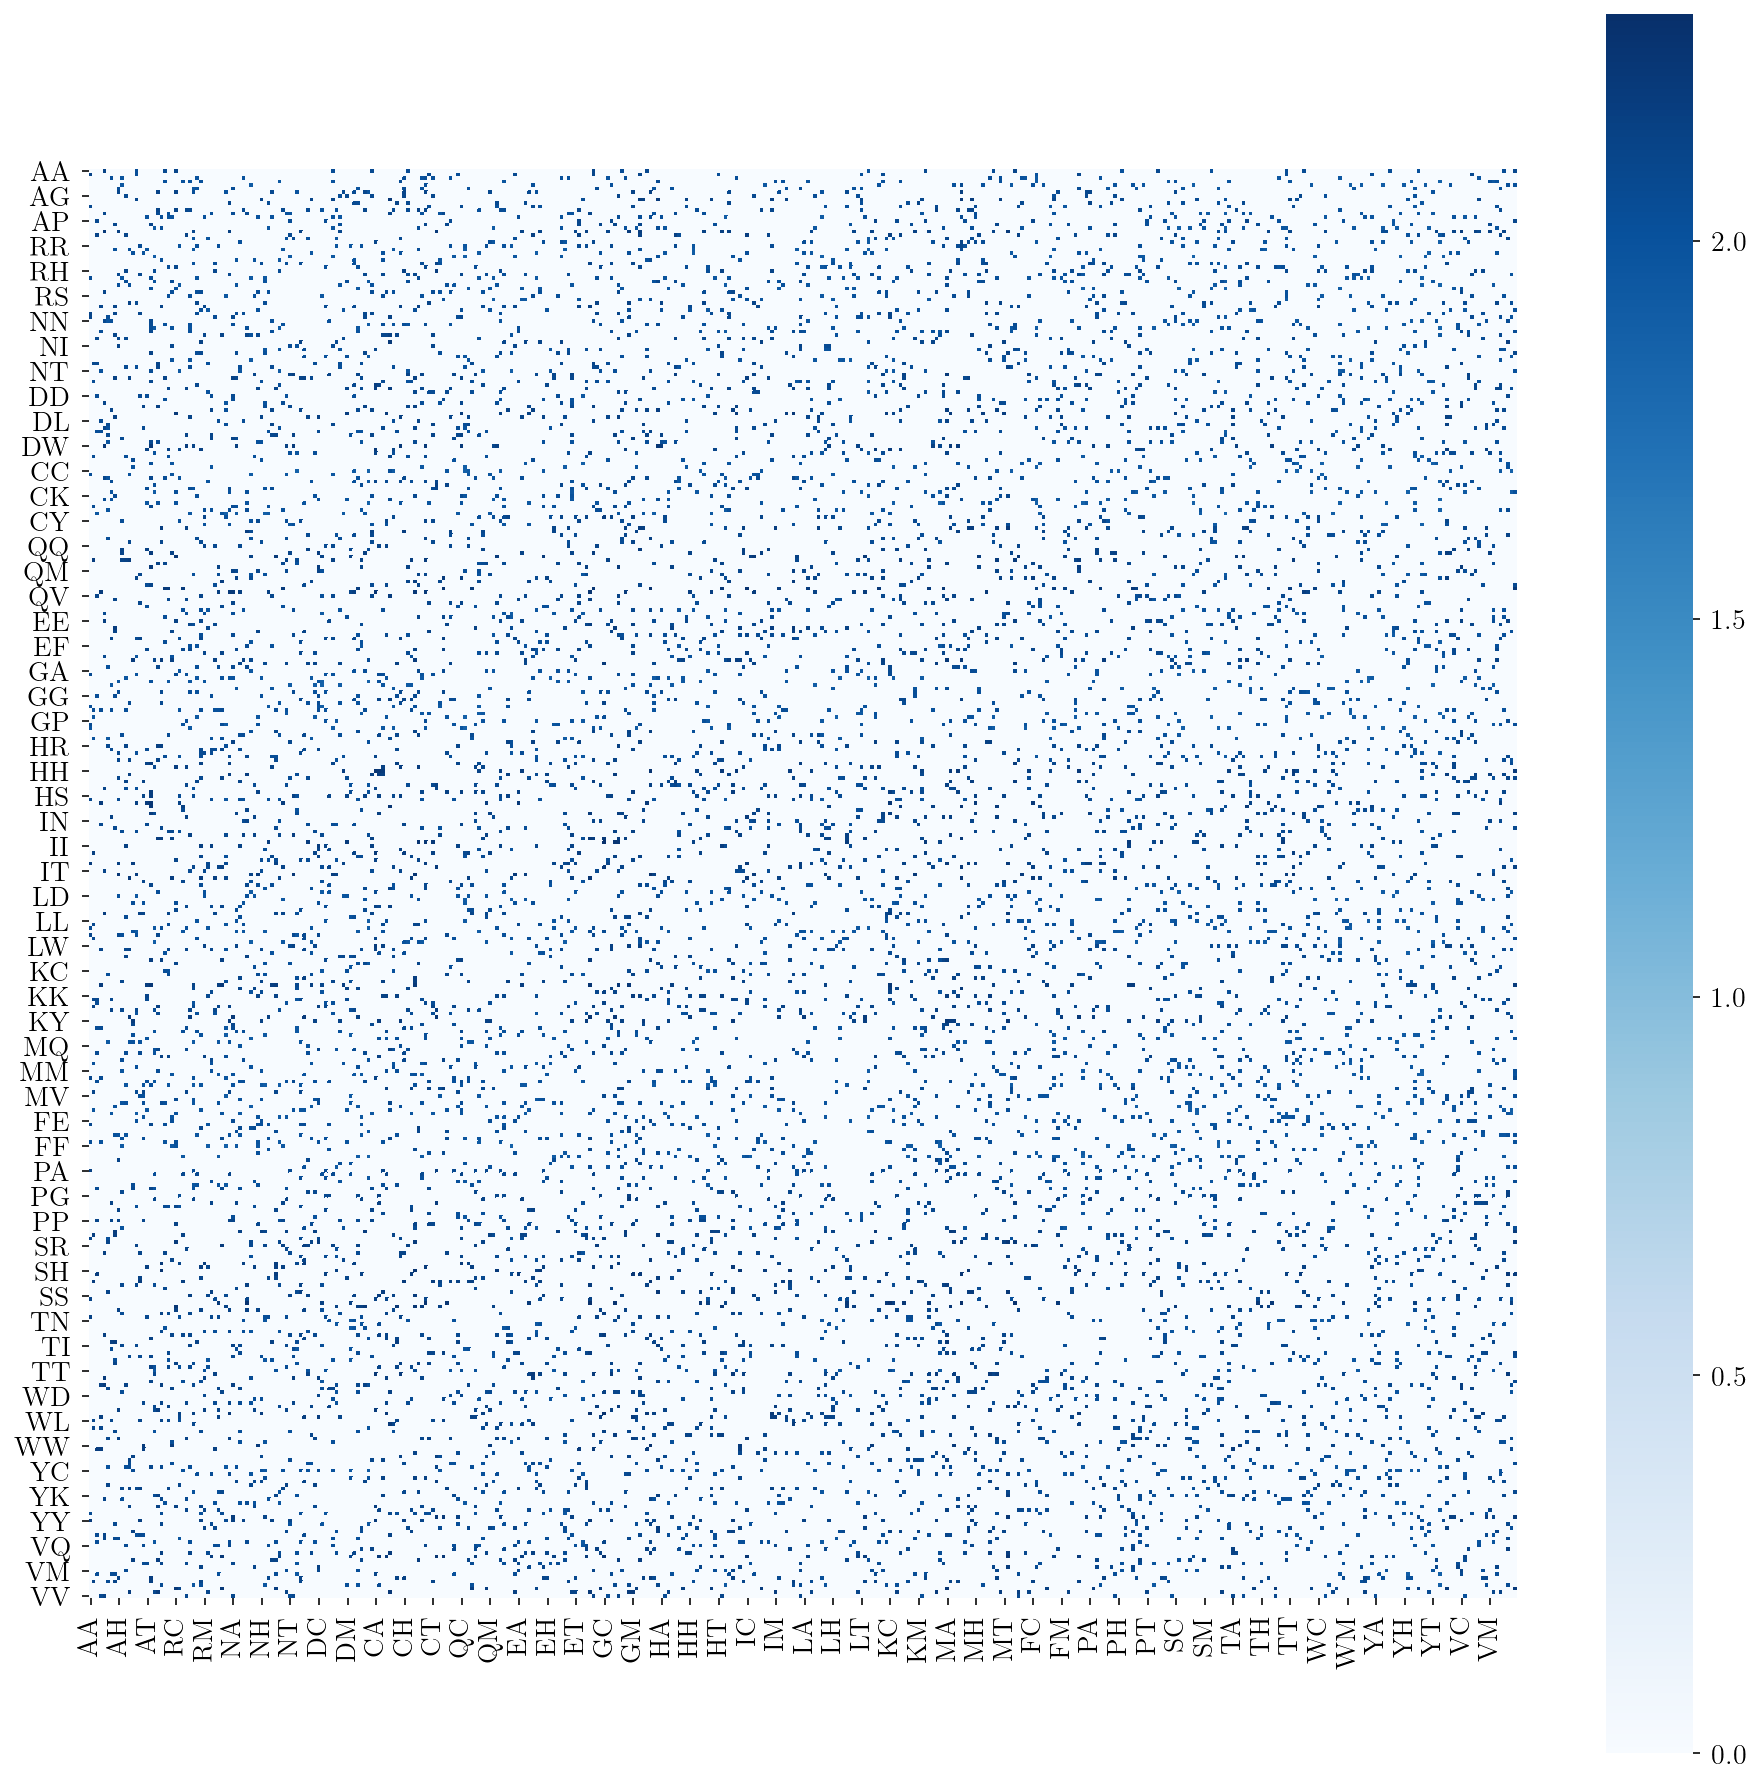

In [29]:
plt.figure(figsize=(16,16))
sns.heatmap(fitness_df, cmap='Blues', square=True)

### Hilbert curve projection

In [30]:
def hilbert(order):
    U = (-1, 0)
    R = (0, 1)
    D = (1, 0)
    L = (0, -1)

    URDR = (U, R, D, R)
    RULU = (R, U, L, U)
    URDD = (U, R, D, D)
    LDRR = (L, D, R, R)
    RULL = (R, U, L, L)
    DLUU = (D, L, U, U)
    LDRD = (L, D, R, D)
    DLUL = (D, L, U, L)

    inception = {
        URDR: (RULU, URDR, URDD, LDRR),
        RULU: (URDR, RULU, RULL, DLUU),
        URDD: (RULU, URDR, URDD, LDRD),
        LDRR: (DLUL, LDRD, LDRR, URDR),
        RULL: (URDR, RULU, RULL, DLUL),
        DLUU: (LDRD, DLUL, DLUU, RULU),
        LDRD: (DLUL, LDRD, LDRR, URDD),
        DLUL: (LDRD, DLUL, DLUU, RULL)
    }

    pos = [(2 ** order) - 1, 0, 0]  # y, x, linear

    def walk(steps, level):
        if level > 1:
            for substeps in inception[steps]:
                for subpos in walk(substeps, level - 1):
                    yield subpos
        else:
            for step in steps:
                yield pos
                pos[0] += step[0]  # y
                pos[1] += step[1]  # x
                pos[2] += 1  # linear

    return walk(URDR, order)

In [31]:
order = 9
ntotal = (2**order)**2
loc = np.zeros((ntotal, 2), dtype=np.int)
for point in hilbert(order):
    loc[point[-1]] = point[:2]

In [32]:
combs_4char = generator.gen(n=4)
seq_val_map = dict(zip(char_seqs, mu_oracle))
mask = np.array([seq_val_map.get(seq, 0) for seq in combs_4char])

In [33]:
vals = np.zeros(ntotal)
vals[:len(mask)] = mask

# Place values at specified locations
out = np.zeros((2**order, 2**order))
for (x,y), v in zip(loc, vals):
    out[x,y] = v

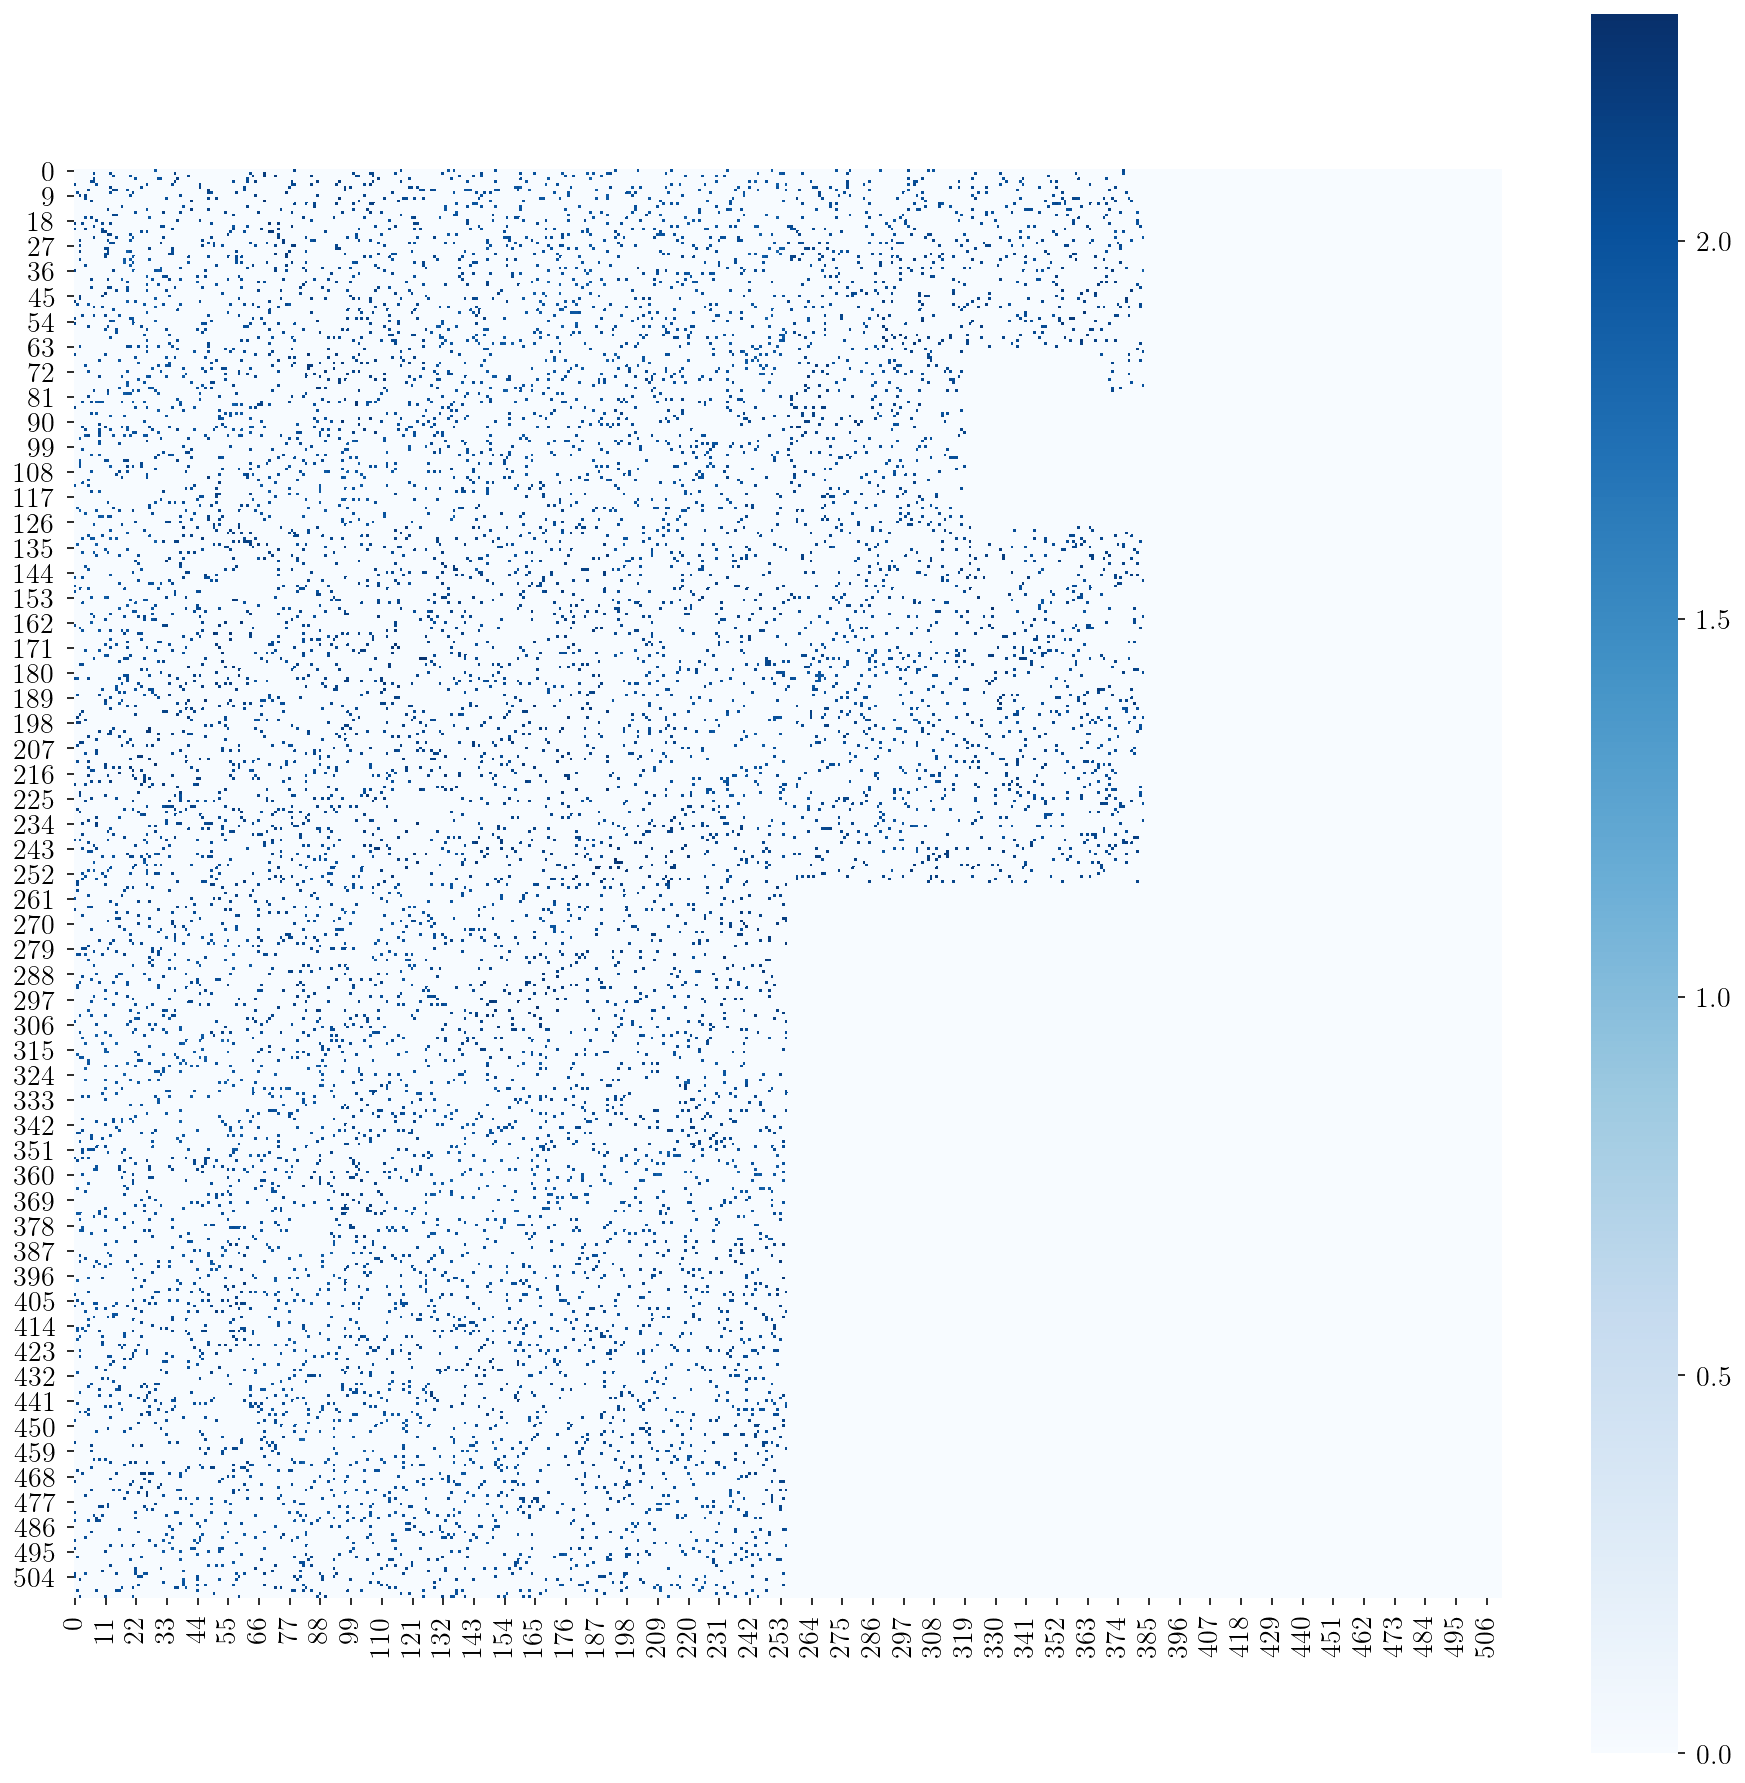

In [34]:
plt.figure(figsize=(16,16))
sns.heatmap(out, cmap="Blues", square=True)

## CbAS-generated sequences

### Load sequences

In [35]:
with open("../../dumps/3gb1/cbas/oracle=g-mean__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)
gmean_seqs_cbas = np.array(results["seq"])
y_cbas = np.array(results["y_oracle"])
y_gt = np.array(results["y_gt"])

### Preprocess sequences

In [36]:
import re
# Flatten; we don't care about the iterative samples plot (for now)
seqs_cbas = gmean_seqs_cbas.flatten()
y_cbas = y_cbas.flatten()
# Remove sequences that are invalid (aka None)
valid_mask = seqs_cbas != None
valid_seqs = seqs_cbas[valid_mask]
valid_y = y_cbas[valid_mask]
# Remove sequences that don't follow WT template (except at mutated positions)
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
aa20_regex = "|".join(list(tokenizer.vocab.keys()))
pos = [38, 39, 40, 53]
for idx in pos:
    template[idx] = f"[{aa20_regex}]"
regex_pattern = "".join(template)

seq_mask = np.array([True if re.findall(regex_pattern, seq, re.IGNORECASE) != [] else False
                     for seq in valid_seqs])

valid_seqs = valid_seqs[seq_mask]
valid_y = valid_y[seq_mask]
# Keep only first instance of unique seqs
_, unique_idx = np.unique(valid_seqs, return_index=True)
unique_seqs = valid_seqs[unique_idx]
unique_y = valid_y[unique_idx]
# Split each seq into individual char
unique_seqs = np.array([list(seq) for seq in unique_seqs])

unique_seqs.shape, unique_y.shape

((5959, 56), (5959,))

### Normal projection

In [37]:
unique_char_seqs = ["".join(seq) for seq in unique_seqs[:, pos]]
combs = generator.gen(n=2)
fitness_df = pd.DataFrame(0.0, index=combs, columns=combs)
# Place fitness values into df
for variant, fitness in zip(unique_char_seqs, unique_y):
    x, y = variant[:2], variant[2:]
    fitness_df.at[x,y] = fitness
fitness_df.head()

,AA,AR,AN,AD,AC,AQ,AE,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AR,0.0,0.0,0.0,0.0,0.0,0.0,2.076491,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AD,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.028802
AC,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


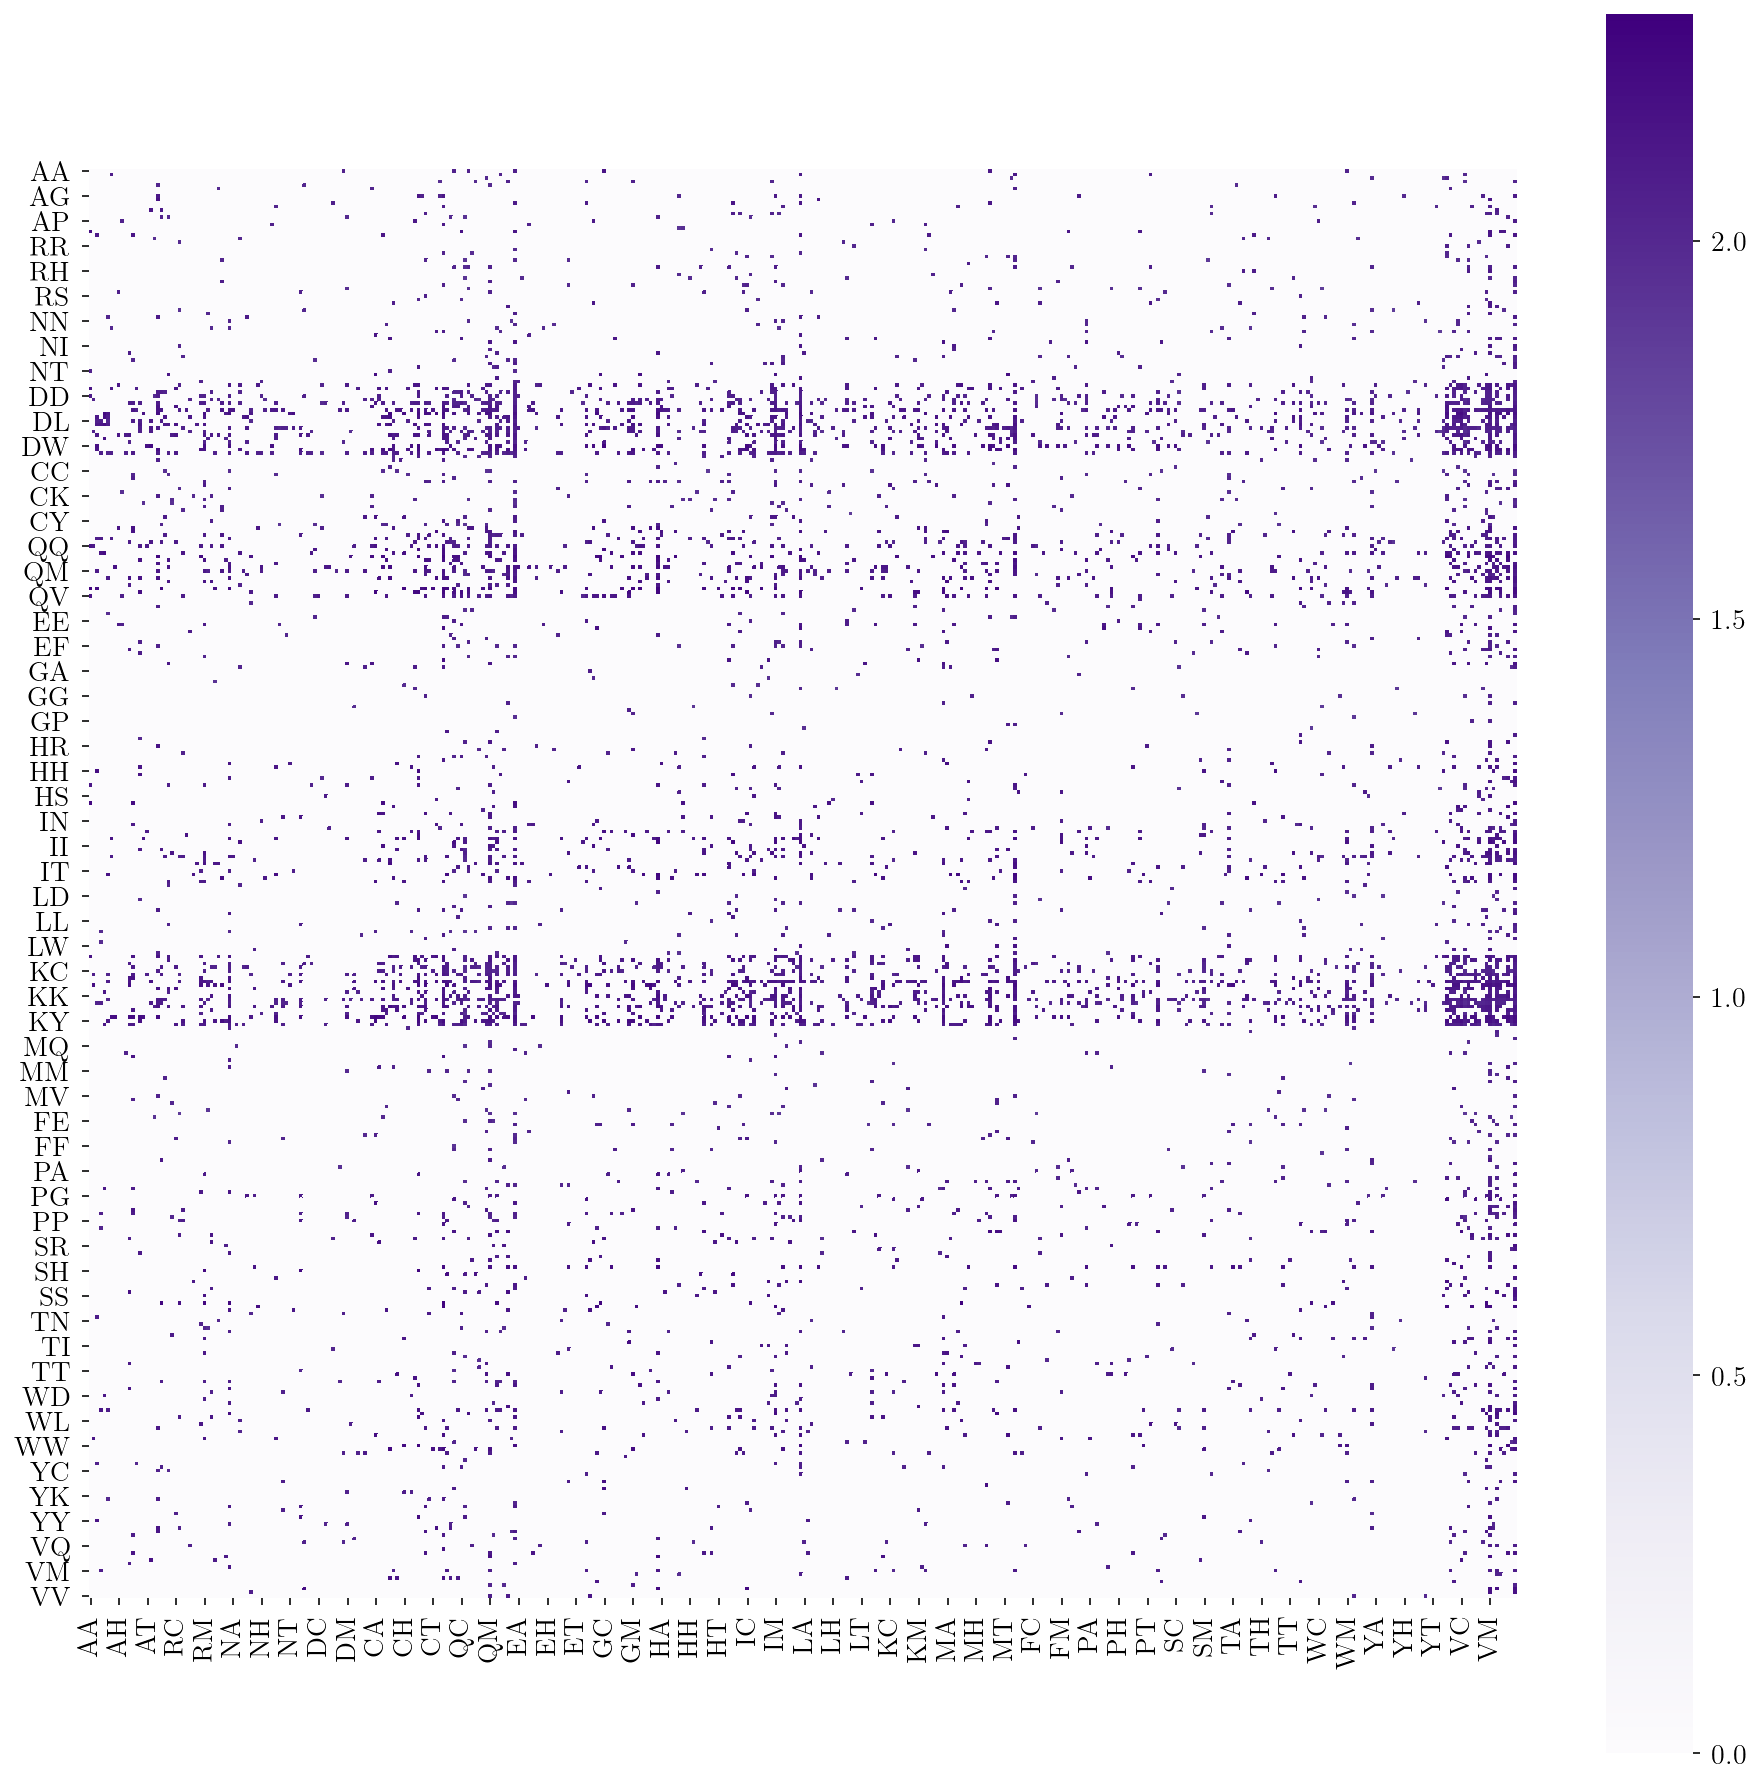

In [38]:
plt.figure(figsize=(16,16))
sns.heatmap(fitness_df, cmap='Purples', square=True)

Notice how the CbAS procedure focuses on looking at sequences that are good (based off oracle). This can be observed by the fact that certain lines are more densely sampled and "observed". Compared to random sequences, notice that the values predicted are (on average) better.

### Hilbert curve projection

In [39]:
order = 9
ntotal = (2**order)**2
loc = np.zeros((ntotal, 2), dtype=np.int)
for point in hilbert(order):
    loc[point[-1]] = point[:2]

In [40]:
combs_4char = generator.gen(n=4)
seq_val_map = dict(zip(["".join(seq) for seq in unique_char_seqs], unique_y))

mask = np.array([seq_val_map.get(seq, 0) for seq in combs_4char])

In [41]:
vals = np.zeros(ntotal)
vals[:len(mask)] = mask

# Place values at specified locations
out = np.zeros((2**order, 2**order))
for (x,y), v in zip(loc, vals):
    out[x,y] = v

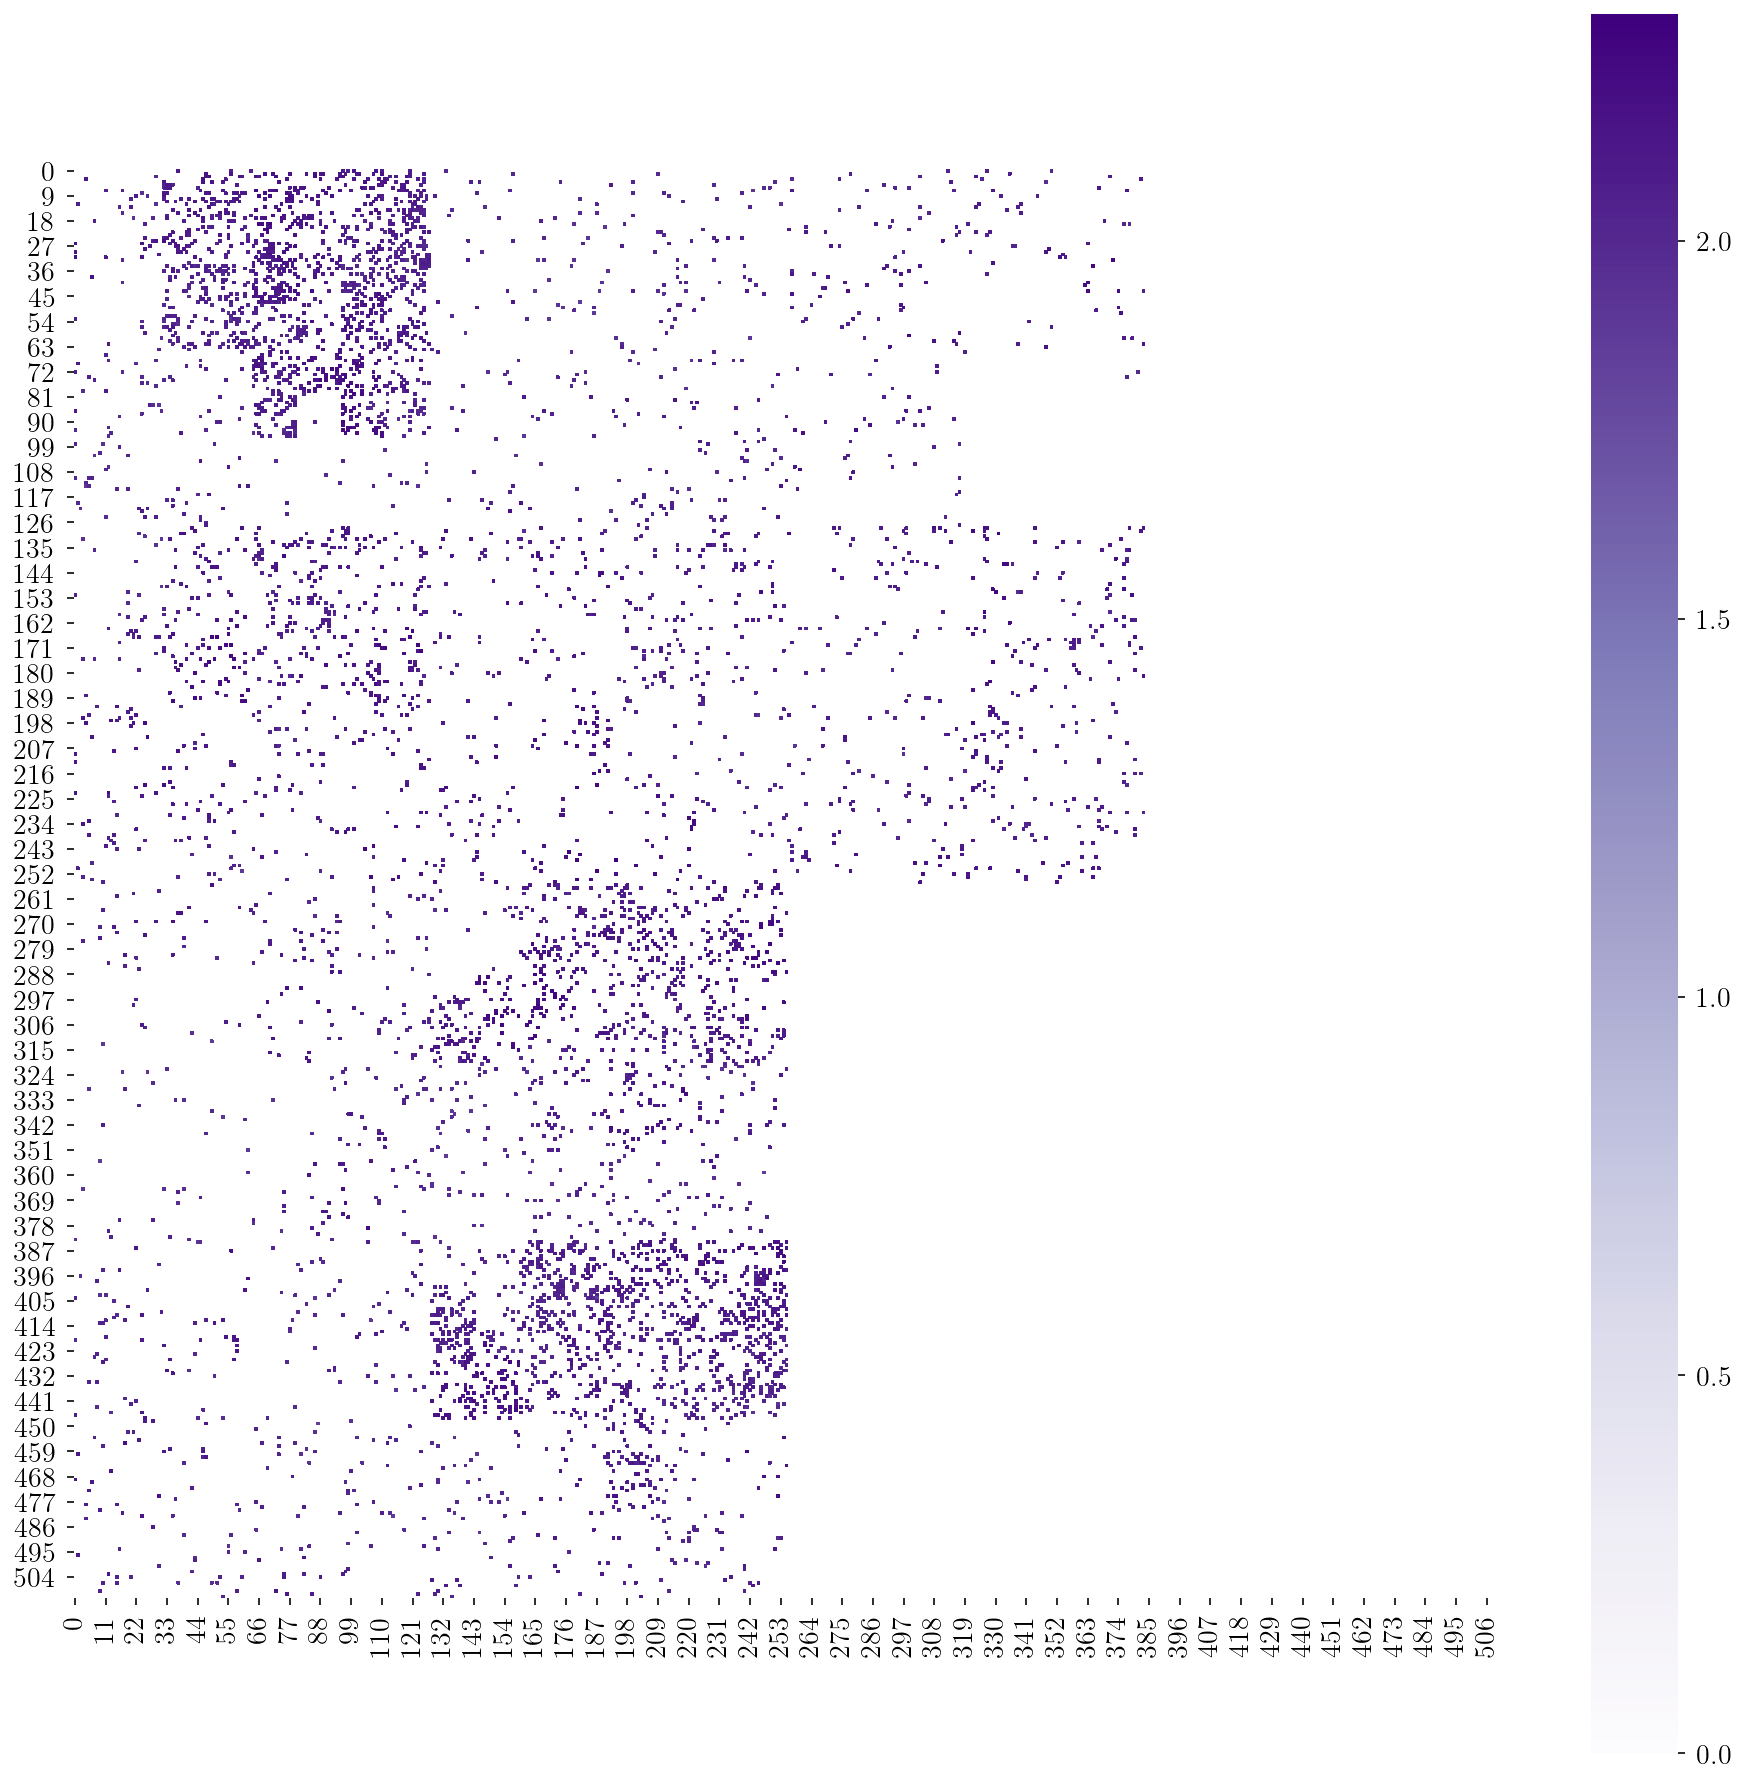

In [42]:
plt.figure(figsize=(16,16))
sns.heatmap(out, cmap="Purples", square=True, mask=(out == 0))

# Random vs designed

Subset the plots by number of mutations from the WT (i.e. hamming distance). What we hope to observe, by using this approach, is that designing protein sequences (with varying amounts of point mutations), does, in fact, result in better fitness than just sampling random mutations from the search space.

NOTE: In this case, it might not be better than random because our oracle is bad at determining the fitness score between sequences. From the oracle's viewpoint, most sequences have the same fitness score (with some minor variance). Maybe the proxy (GT) is a better because it shows that the CbAS is not going into "bad" sequence search space.

## Oracle

Text(0.5, 1.0, 'All Sequences')

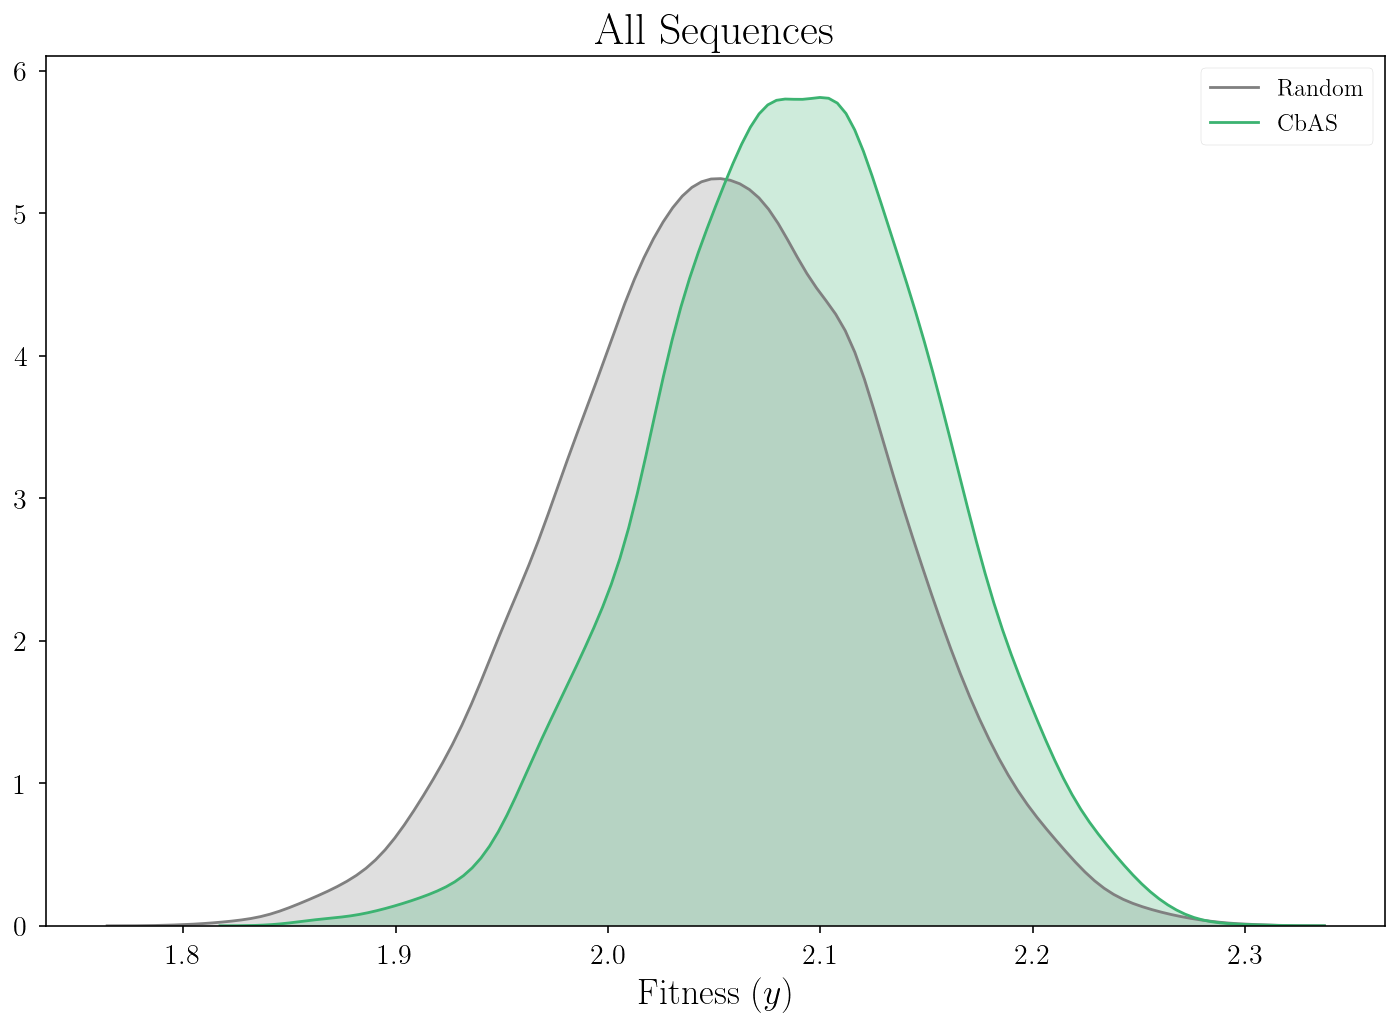

In [43]:
plt.figure(figsize=(12,8))
ax = sns.kdeplot(mu_oracle.numpy(), shade=True, label="Random", color="grey")
ax = sns.kdeplot(unique_y, shade=True, label="CbAS", color="mediumseagreen")
ax.set_xlabel("Fitness ($y$)")
ax.set_title(f"All Sequences")

In [44]:
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
cbas_hamming = (unique_seqs != template).sum(axis=-1)
mutation_classes, cbas_hamming_count = np.unique(cbas_hamming, return_counts=True)

In [45]:
random_hamming = (np.array([tokenizer.decode(seq)
                            for seq in Vaa.numpy()]) != template).sum(axis=-1)
mutation_classes, random_hamming_count = np.unique(random_hamming, return_counts=True)

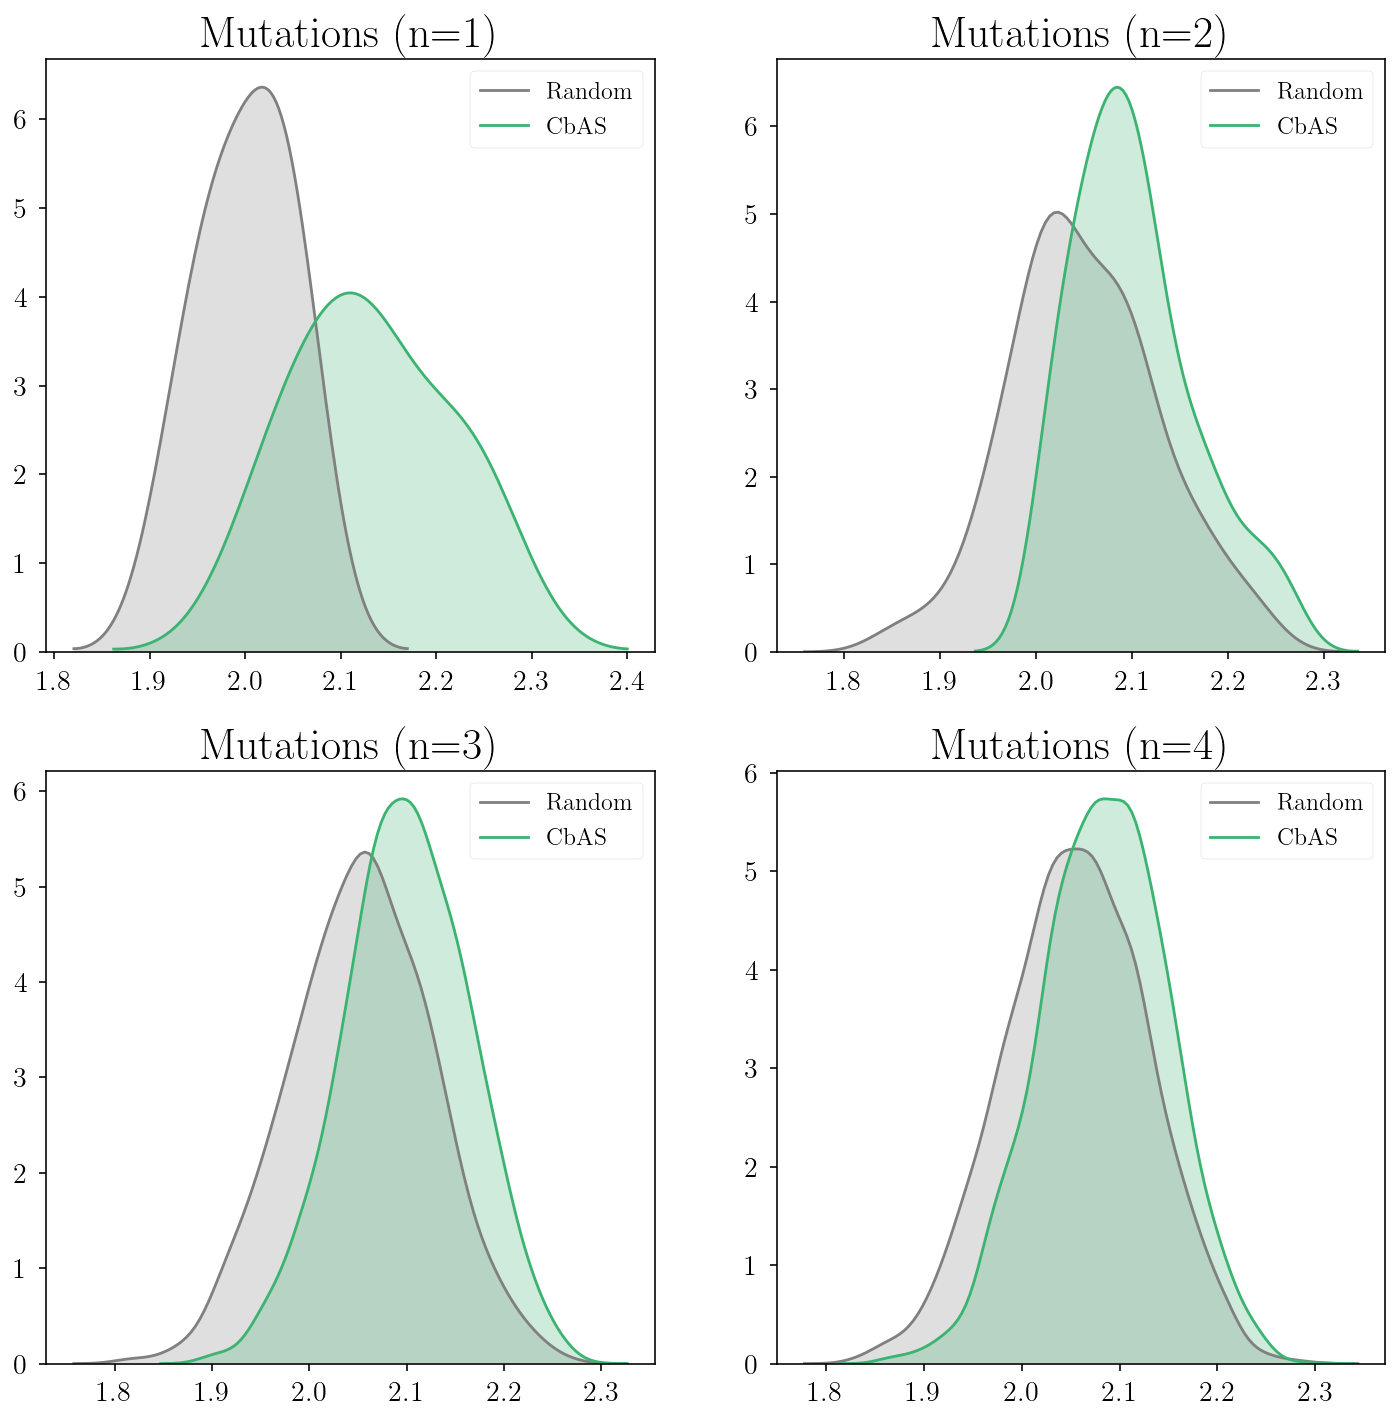

In [46]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ax, t in zip(axarr.flatten(), mutation_classes):
    random_hamming_mean = mu_oracle[np.where(cbas_hamming == t)]
    cbas_hamming_mean = unique_y[np.where(cbas_hamming == t)]
    sns.kdeplot(random_hamming_mean.numpy(), shade=True, label="Random", color="grey", ax=ax)
    sns.kdeplot(cbas_hamming_mean, shade=True, label="CbAS", color="mediumseagreen", ax=ax)
    ax.set_title(f"Mutations (n=${t}$)")

Maybe we should plot the multivariate distribution for both the oracle and GT to compare it to the hamming distance. Would that really do anything??

## GP (Ground Truth)

In [47]:
Vaa = dataset[:]["arr_0"].long()

# Evaluate on (g-mean) GP to get GT predictions
gmean_gp = all_gps["g-mean"]
mu_gt, sigma_gt = gmean_gp.predict(Vaa, return_std=True)
mu_gt, sigma_gt = mu_gt.squeeze().numpy(), sigma_gt.squeeze().numpy()

In [48]:
# Flatten; we don't care about the iterative samples plot (for now)
seqs_cbas = gmean_seqs_cbas.flatten()
y_gt = y_gt.flatten()
# Remove sequences that are invalid (aka None)
valid_mask = seqs_cbas != None
valid_seqs = seqs_cbas[valid_mask]
valid_y_gt = y_gt[valid_mask]
# Remove sequences that don't follow WT template (except at mutated positions)
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
aa20_regex = "|".join(list(tokenizer.vocab.keys()))
pos = [38, 39, 40, 53]
for idx in pos:
    template[idx] = f"[{aa20_regex}]"
regex_pattern = "".join(template)

seq_mask = np.array([True if re.findall(regex_pattern, seq, re.IGNORECASE) != [] else False
                     for seq in valid_seqs])

valid_seqs = valid_seqs[seq_mask]
valid_y_gt = valid_y_gt[seq_mask]
# Keep only first instance of unique seqs
_, unique_idx = np.unique(valid_seqs, return_index=True)
unique_seqs = valid_seqs[unique_idx]
unique_y_gt = valid_y_gt[unique_idx]
# Split each seq into individual char
unique_seqs = np.array([list(seq) for seq in unique_seqs])

unique_seqs.shape, unique_y_gt.shape

((5959, 56), (5959,))

Text(0.5, 1.0, 'All Sequences')

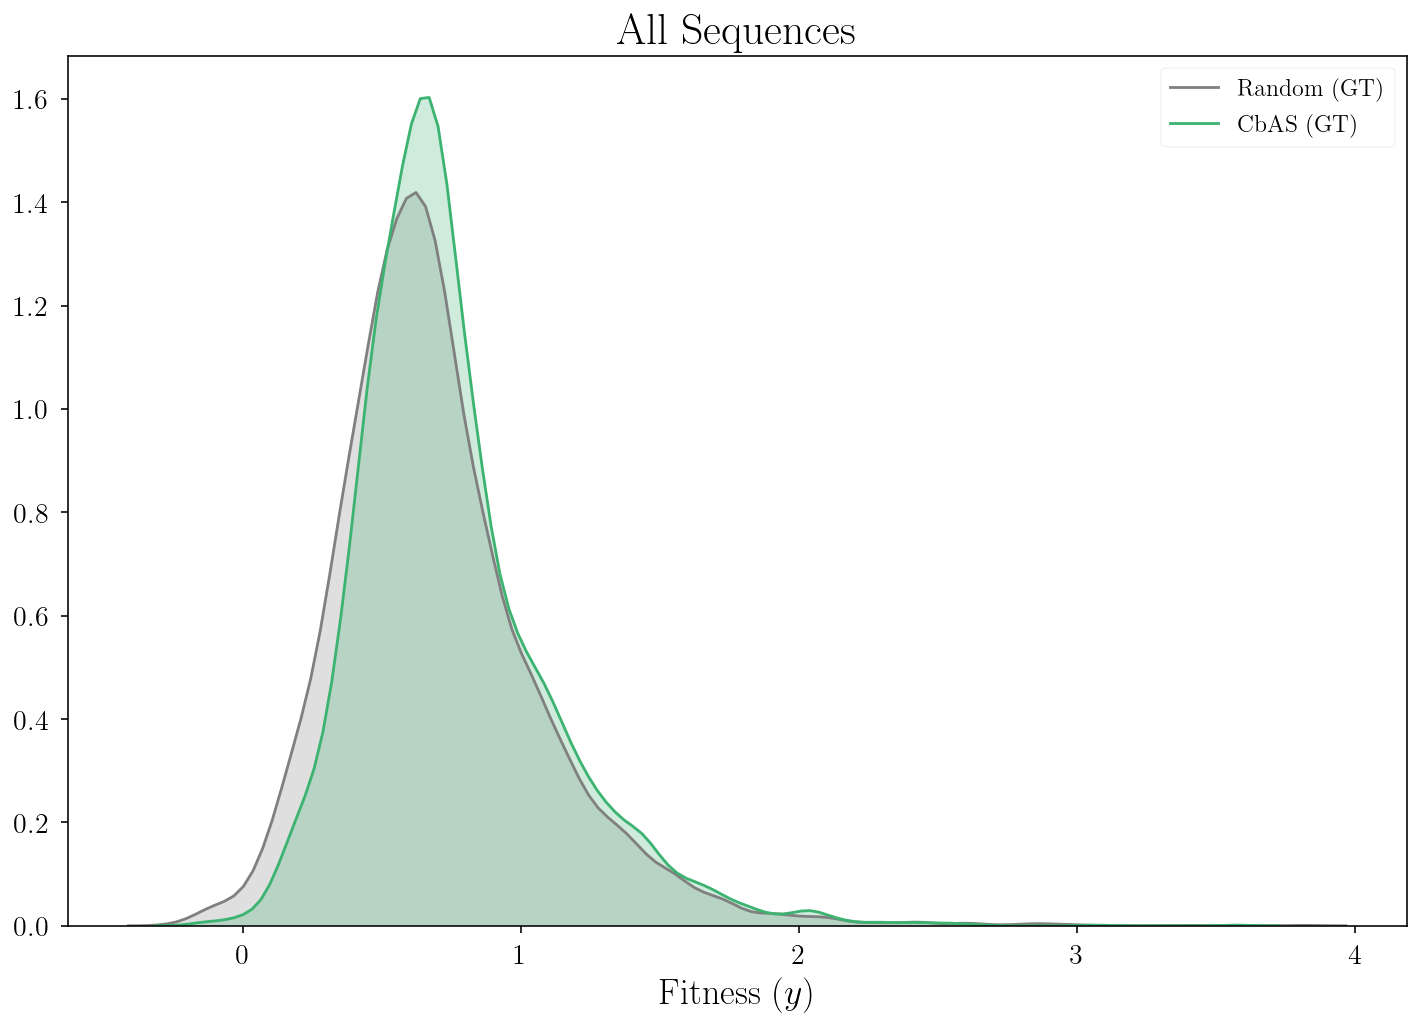

In [49]:
plt.figure(figsize=(12,8))
ax = sns.kdeplot(mu_gt, shade=True, label="Random (GT)", color="grey")
ax = sns.kdeplot(unique_y_gt, shade=True, label="CbAS (GT)", color="mediumseagreen")
ax.set_xlabel("Fitness ($y$)")
ax.set_title(f"All Sequences")

In [50]:
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
cbas_hamming = (unique_seqs != template).sum(axis=-1)
mutation_classes, cbas_hamming_count = np.unique(cbas_hamming, return_counts=True)

In [51]:
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
random_hamming = (np.array([tokenizer.decode(seq)
                            for seq in Vaa.numpy()]) != template).sum(axis=-1)
mutation_classes, random_hamming_count = np.unique(random_hamming, return_counts=True)

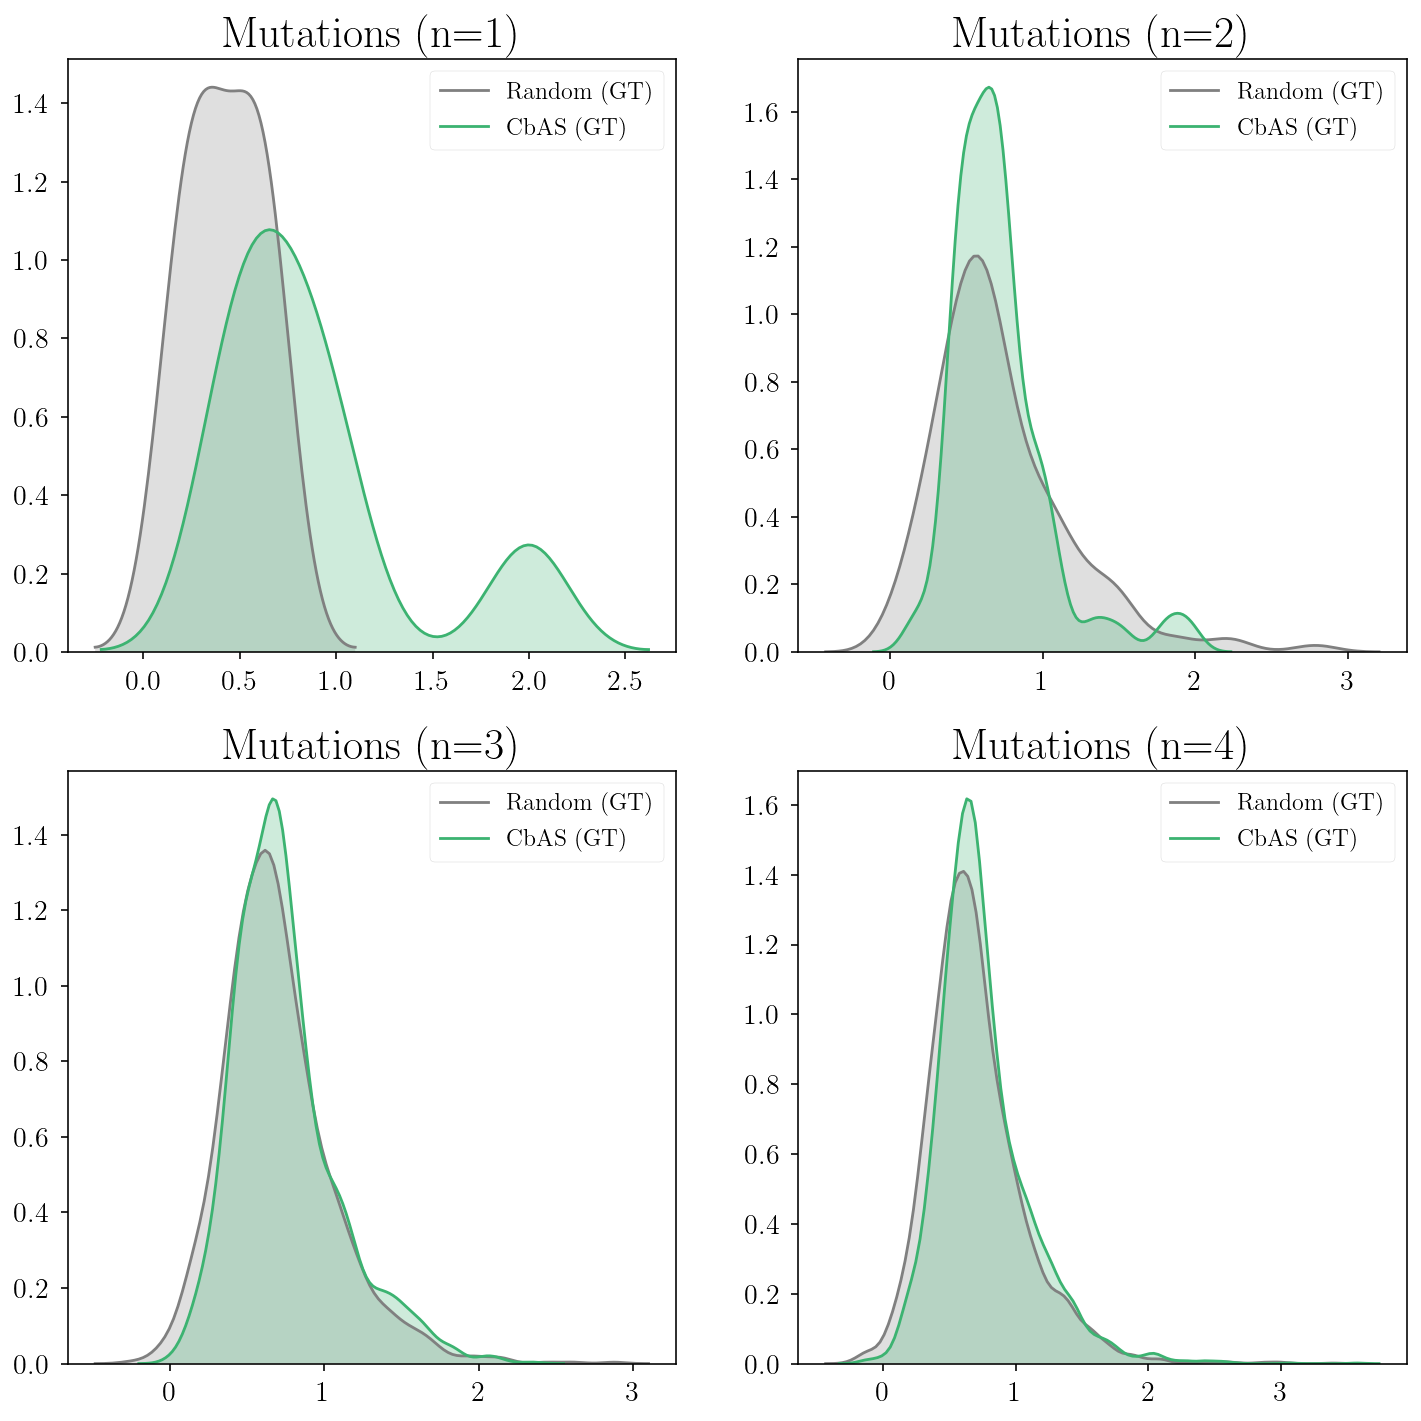

In [52]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ax, t in zip(axarr.flatten(), mutation_classes):
    cbas_hamming_mean_gt = unique_y_gt[np.where(cbas_hamming == t)]
    random_hamming_mean_gt = mu_gt[np.where(cbas_hamming == t)]
    sns.kdeplot(random_hamming_mean_gt, shade=True, label="Random (GT)", color="grey", ax=ax)
    sns.kdeplot(cbas_hamming_mean_gt, shade=True, label="CbAS (GT)", color="mediumseagreen", ax=ax)
    ax.set_title(f"Mutations (n=${t}$)")